## Training GAN to generate data points to conform to the equation $y = 1.08^x$

## Creating the GAN

### Curating a training dataset that forms an exponential growth curve

In [1]:
# generate (x, y) data points with 
# x being uniformly distributed in [0, 50] 
# and y = 1.08^x

import torch

torch.manual_seed(0)    # fixing the random state

observations = 2048

train_data = torch.zeros((observations, 2))  # tensor of size 2048 x 2

train_data[:,0] = 50*torch.rand(observations)   # putting random values between 0 and 50 into first column: x values
train_data[:,1] = 1.08**train_data[:,0]     # getting their correesponding y-values and putting in second column


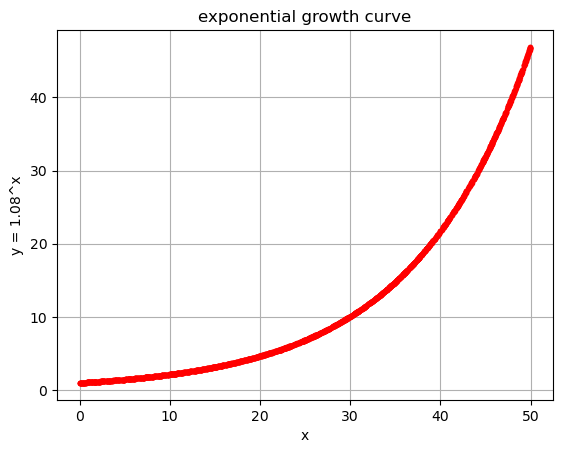

In [2]:
# plotting the points

import matplotlib.pyplot as plt

plt.plot(train_data[:,0], train_data[:,1], ".", c="r")
plt.xlabel("x")
plt.ylabel("y = 1.08^x")
plt.title("exponential growth curve")
plt.grid(True)
plt.show()

In [3]:
# # exercise

# torch.manual_seed(0)

# observations2 = 3000

# train_data2 = torch.zeros((observations2, 2))

# train_data2[:,0] = 10*(torch.rand(observations2)-0.5)
# train_data2[:,1] = torch.sin(train_data2[:,0])

# plt.plot(train_data2[:,0], train_data2[:,1], ".", c="r")
# plt.xlabel("x")
# plt.ylabel("y = sin(x)")
# plt.title("sin curve")
# plt.grid(True)
# plt.show()


In [4]:
# putting the datapoints into batches to feed to the discriminator
# using DataLoader()

from torch.utils.data import DataLoader

batch_size = 128    # a divisor of 2048 so that each batch has same number of samples

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True    # ensure values of x fall randomly between 0 and 50
)

In [5]:
# accessing a batch of data

batch0 = next(iter(train_loader))
batch0.shape   # one batch of size (128, 2) which is what we want

torch.Size([128, 2])

### Creating the discriminator network

In [6]:
import torch.nn as nn

device = "mps" if torch.backends.mps.is_available() else "cpu" # if gpu not available, use cpu

discriminator = nn.Sequential(
    nn.Linear(2, 256),  # inputs = 2 = num of elements in each data instance (x, y)
    nn.ReLU(),
    nn.Dropout(0.3),    # adding droput regularization to prevent overfitting
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 1),   # output in last layer is 1 neuron (real or fake)
    nn.Sigmoid()    # squeeze the value between 0 and 1 to get the prob
).to(device)

### Creating the generator network

In [7]:
generator = nn.Sequential(
    nn.Linear(2, 16),  # inputs = 2 = dim of random noise vector (z1, z2)
    nn.ReLU(),
    nn.Linear(16, 32), 
    nn.ReLU(),
    nn.Linear(32, 2),  # outputs = 2 = num of elements in each data instance (x, y)
).to(device)

In [8]:
loss_func = nn.BCELoss()  # use binary cross-entropy for both networks as both are essentially binary classifiers
learning_rate = 0.0005

optim_d = torch.optim.Adam(discriminator.parameters(), lr=learning_rate) # setting Adam as the optimizer for discrimnator
optim_g = torch.optim.Adam(generator.parameters(), lr=learning_rate) # setting Adam as the optimizer for generator too

In GANs, the loss of the discriminator network is not a good indicator of the GAN's quality.
    - Obviously because a low disc. loss means our generator is performing bad, which isn't what we want. 


Common method in this scenario is to measure the GAN's performance through *visual inspection*.
- Humans can assess the quality of generated instances by simply looking at them. 
- Qualitative approach, but works well.

- For our case, since we already know the distribution of the training data, we can just use MSE.

In [9]:
mse = nn.MSELoss()

def performance(fake_samples):
    real = 1.08**fake_samples[:,0]
    mseloss = mse(fake_samples[:,1], real)
    return mseloss

In [10]:
# also define an EarlyStopper class like earlier

class EarlyStopper():
    def __init__(self, patience=1000):      # using a patience epoch of 1000
        self.patience = patience
        self.steps = 0  # counter for epochs/steps without improvement
        self.min_gen_diff = float('inf') # setting the difference to a big value
    
    def stop(self, gen_diff):
        if gen_diff < self.min_gen_diff:    # found a smaller diff
            self.min_gen_diff = gen_diff # set min to that value
            self.steps = 0 # reset the counter
        elif gen_diff >= self.min_gen_diff: # if not
            self.steps +=1  # increment the counter
        if self.steps >= self.patience: #if we're over the patience limit
            return True # signal to stop
        else:
            return False # if not, continue
        
stopper = EarlyStopper()


## Training and using the GAN

In [11]:
# labels for real and fake samples
# real samples: 1s, fake samples: 0s

real_labels = torch.ones((batch_size, 1))
real_labels = real_labels.to(device)

fake_labels = torch.zeros((batch_size, 1))
fake_labels = fake_labels.to(device)

In [12]:
# training the GAN

# func to train discriminator on a batch of real samples
def train_D_on_real(real_samples):
    real_samples = real_samples.to(device) #move samples to gpu
    optim_d.zero_grad() # reset grads before backprop to use incremental grads instead of accumulated grads
    output_d = discriminator(real_samples)  # make predictions
    loss_d = loss_func(output_d, real_labels) # calculate the loss
    loss_d.backward() # calculate grads w.r.t. params
    optim_d.step() # update the params
    return loss_d


# func to train discriminator on a batch of fake samples
def train_D_on_fake():
    noise = torch.randn((batch_size, 2))
    noise = noise.to(device) 
    fake_samples = generator(noise)
    optim_d.zero_grad()
    output_d = discriminator(fake_samples)
    loss_d = loss_func(output_d, fake_labels)
    loss_d.backward()
    optim_d.step()
    return loss_d


# func to train generator on a batch of fake samples
def train_G():
    noise = torch.randn((batch_size, 2))
    noise = noise.to(device) 
    fake_samples = generator(noise) # create batch of fake samples
    optim_g.zero_grad() 
    output_g = discriminator(fake_samples) # make predictions on those fake_samples
    loss_g = loss_func(output_g, real_labels) # calculate the loss
    loss_g.backward()
    optim_g.step()  # update weights
    return loss_g, fake_samples


In [13]:
# testing
# prints losses for G and D
# plots data points generated by G and compares to real data in training set

import os
os.makedirs("files", exist_ok=True)     # folder ot hold files

def test_epoch(epoch, g_loss, d_loss, n, fake_samples):
    if epoch==0 or (epoch+1)%25==0:     # print average losses after every 25 epochs
        g=g_loss.item()/n
        d=d_loss.item()/n
        print(f"epoch {epoch+1}, G_loss: {g}, D_loss {d}")
        fake=fake_samples.detach().cpu().numpy()
        plt.figure(dpi=200)
        plt.plot(fake[:,0],fake[:,1],"*",c="g",     # plots fake data points
            label="generated samples")
        plt.plot(train_data[:,0],train_data[:,1],".",c="r",     # plot real data points (training)
            alpha=0.1,label="real samples")
        plt.title(f"epoch {epoch+1}")
        plt.xlim(0,50)
        plt.ylim(0,50)
        plt.legend()
        plt.savefig(f"files/p{epoch+1}.png")    # save image in the local folder /files/
        plt.show()

epoch 1, G_loss: 0.7798790613810221, D_loss 0.8431968688964844


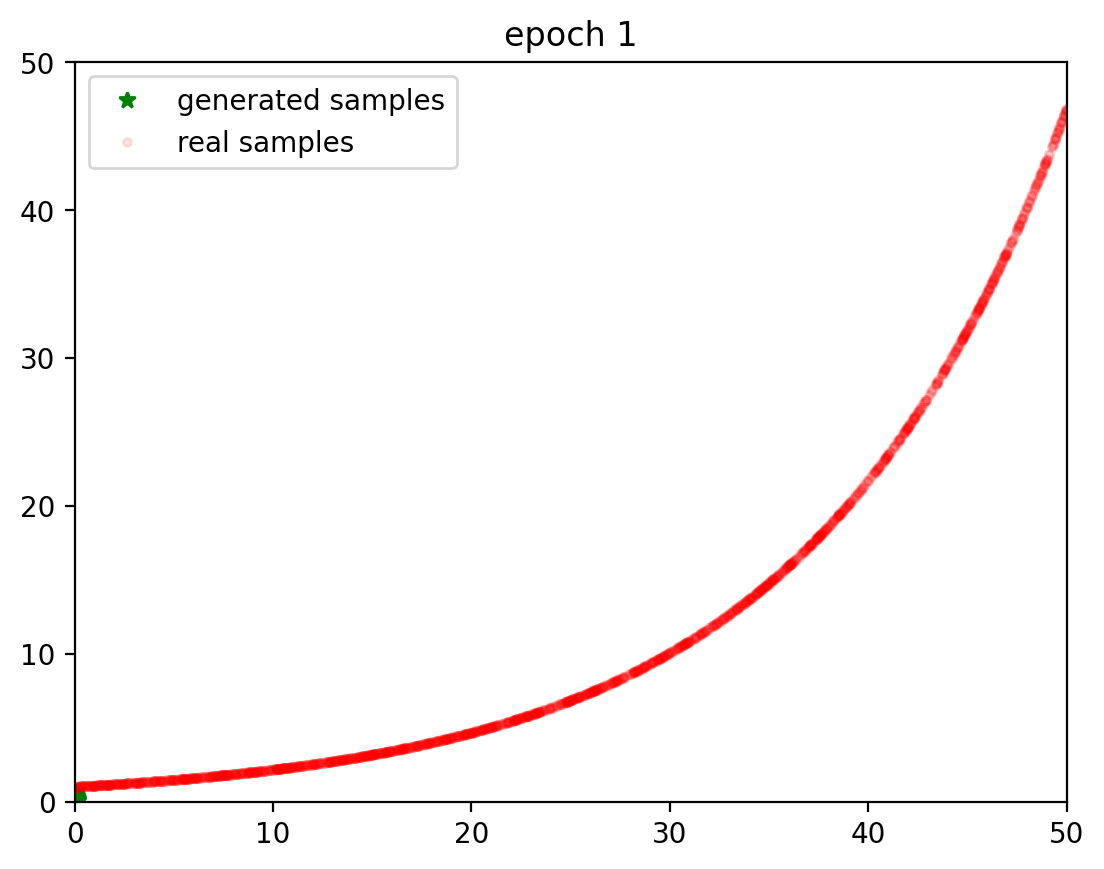

epoch 25, G_loss: 2.3628921508789062, D_loss 0.5016147931416829


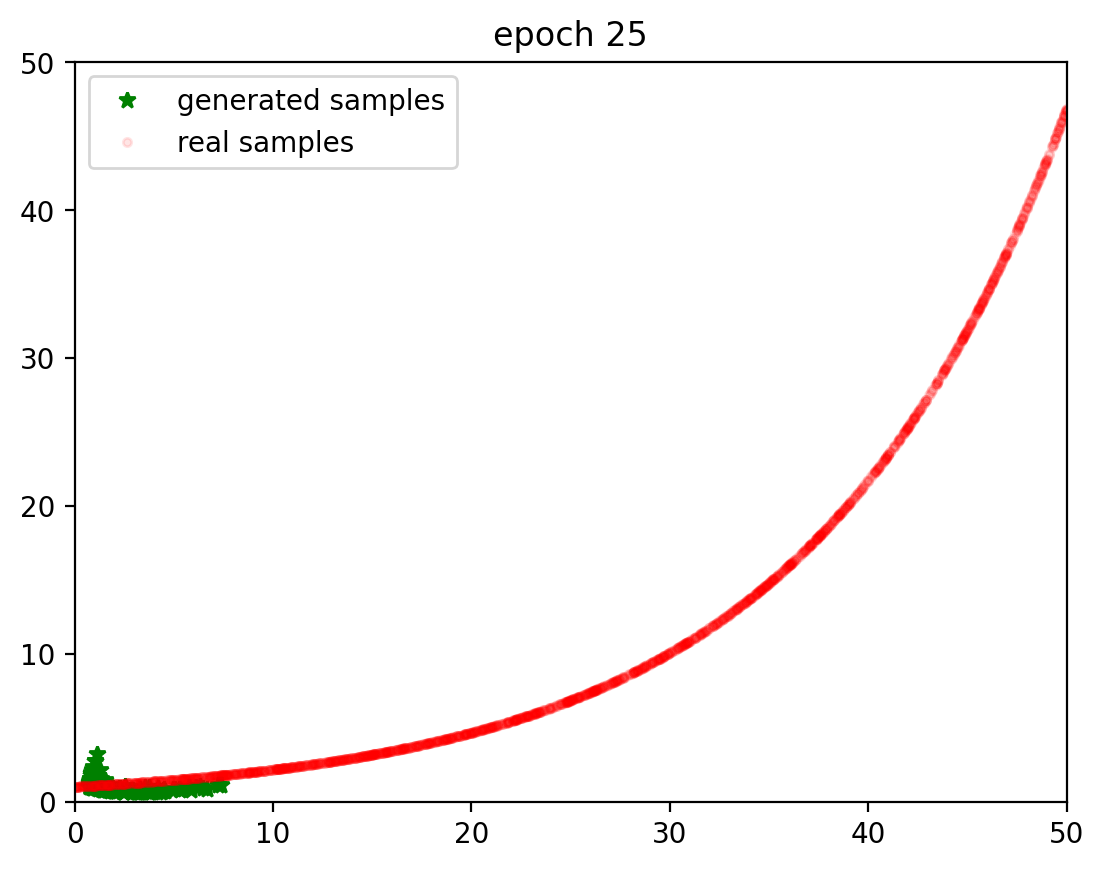

epoch 50, G_loss: 1.568706258138021, D_loss 0.8725469589233399


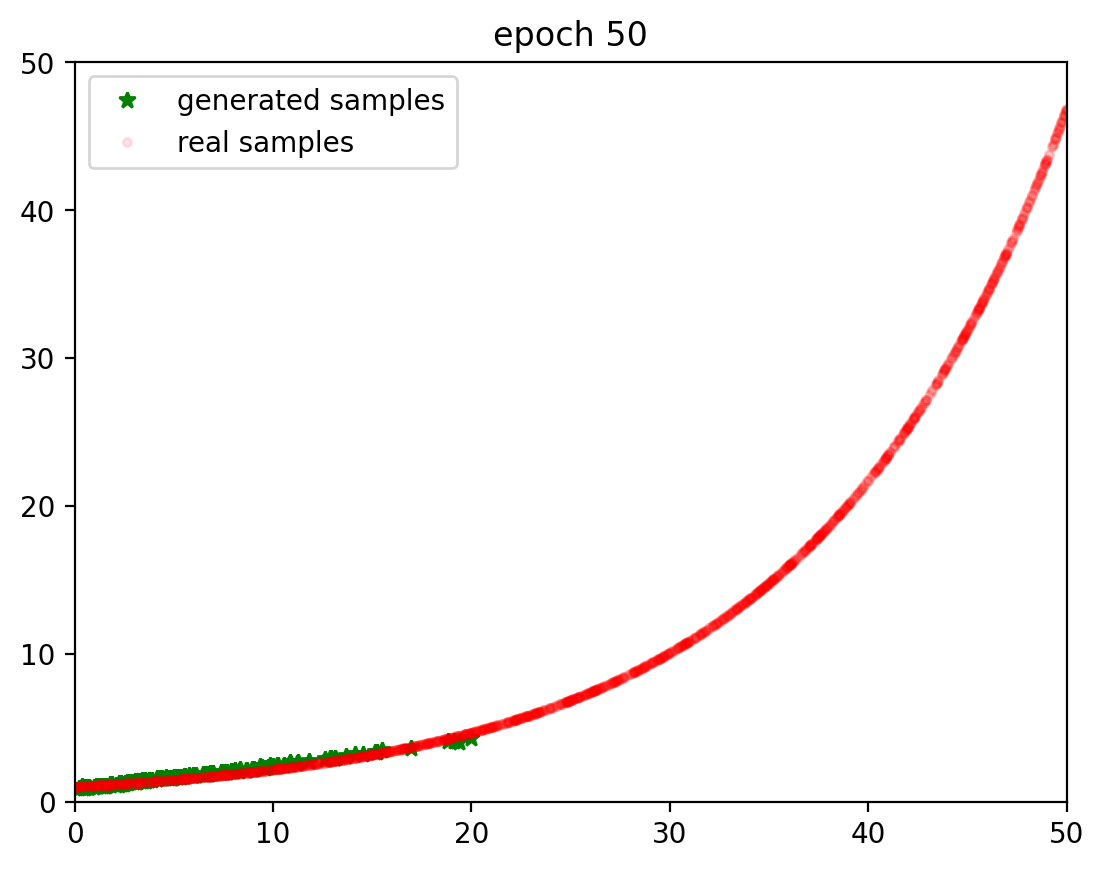

epoch 75, G_loss: 1.1977362314860025, D_loss 1.035664176940918


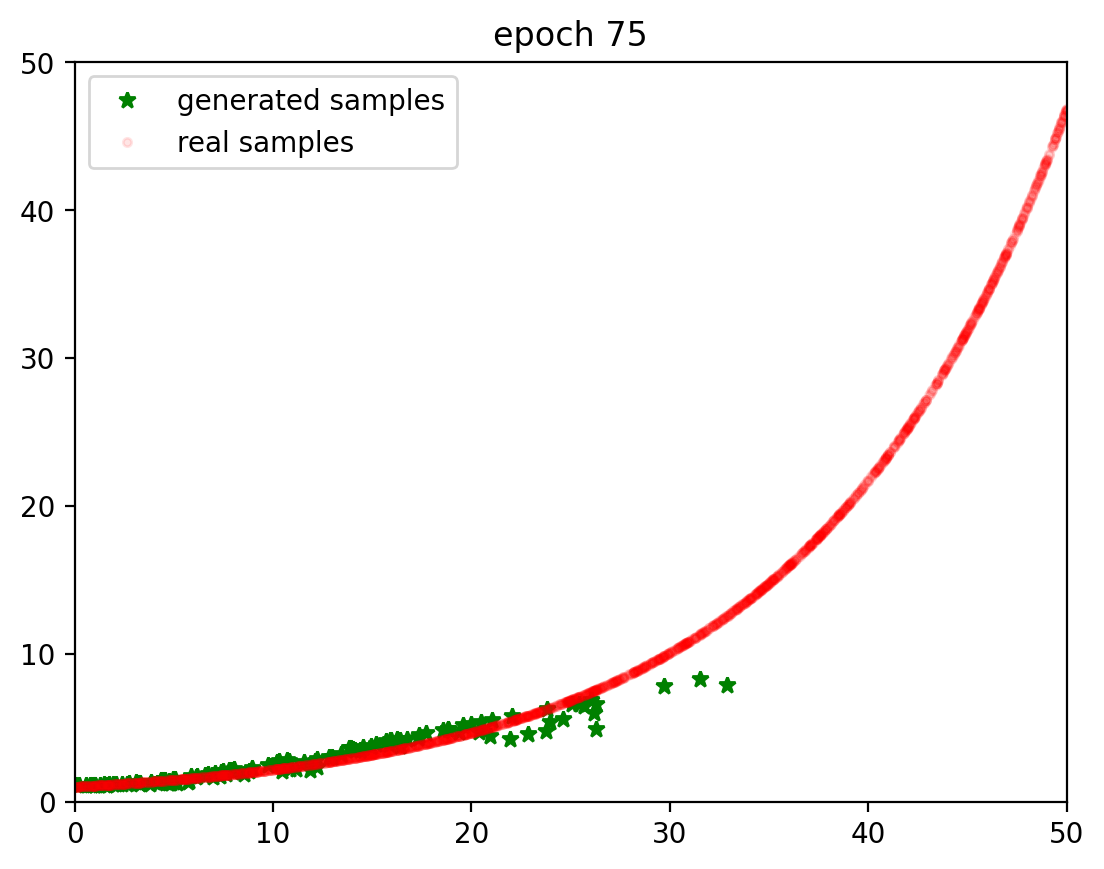

epoch 100, G_loss: 1.0852985382080078, D_loss 1.1127616882324218


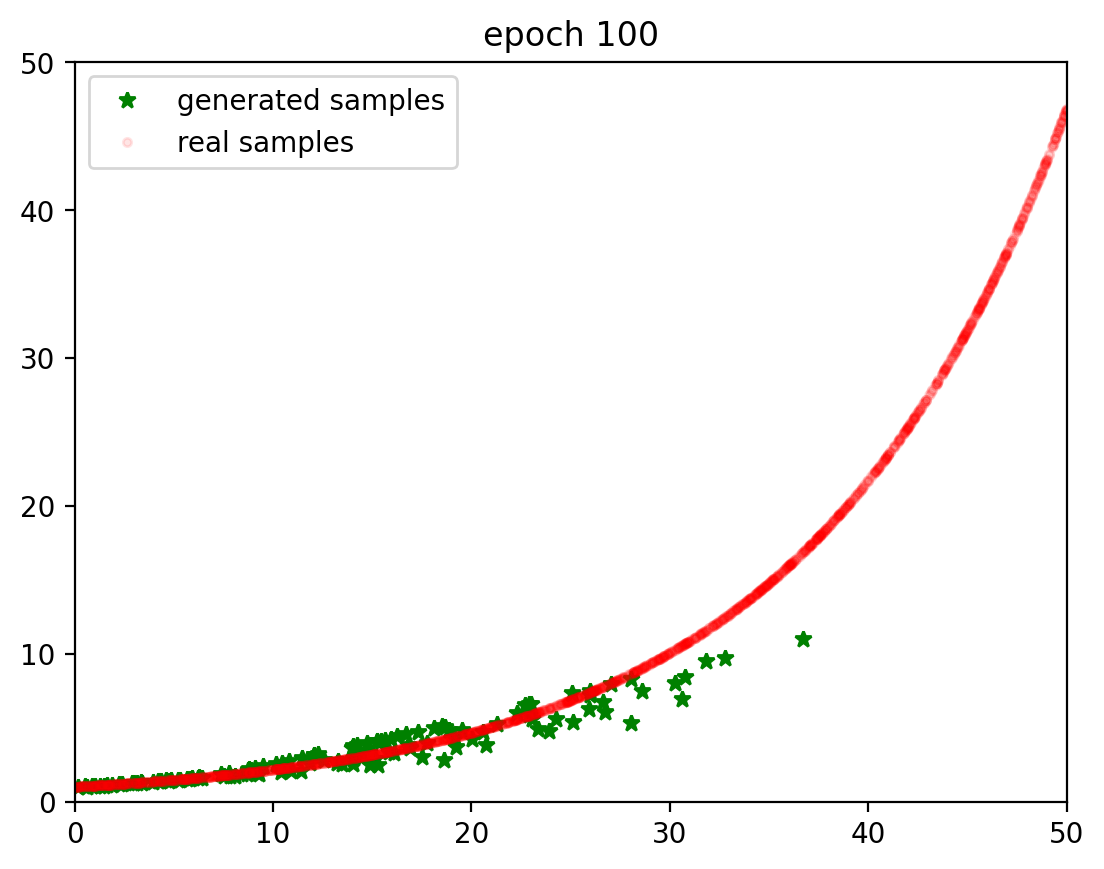

epoch 125, G_loss: 1.0534114201863607, D_loss 1.1551282246907553


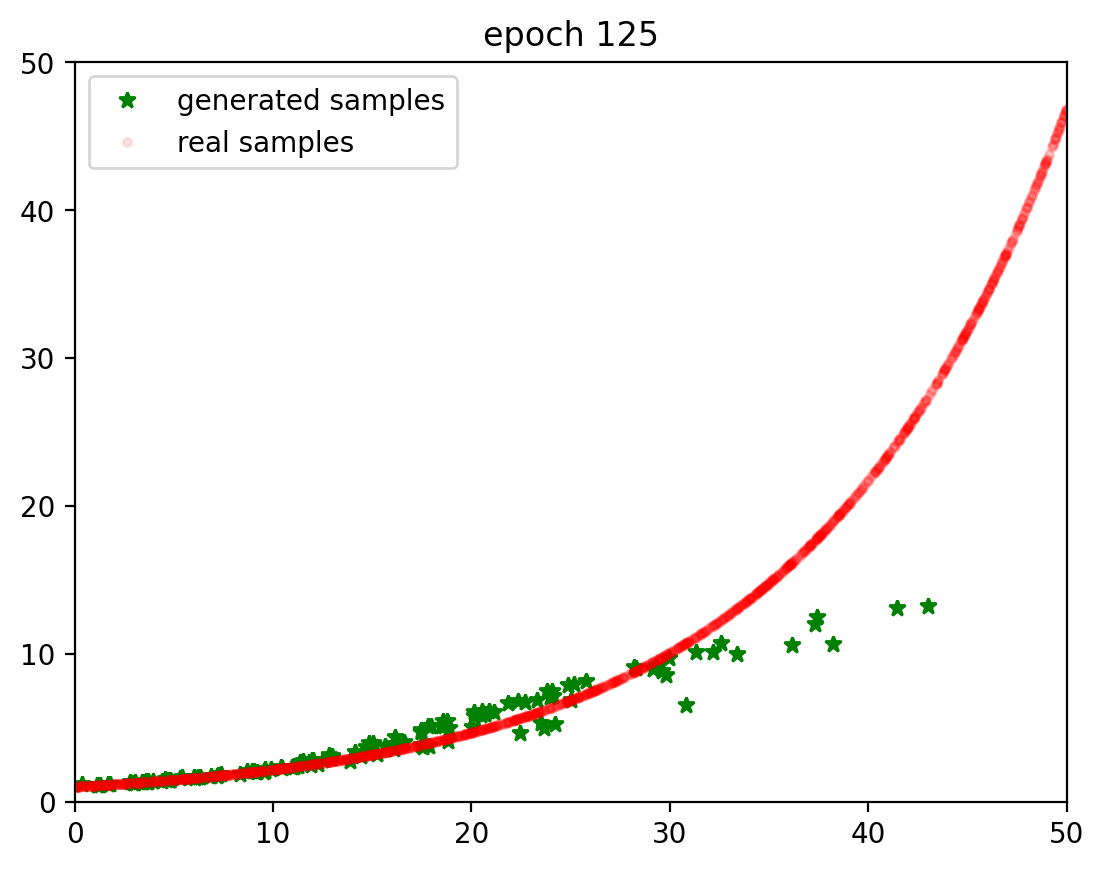

epoch 150, G_loss: 0.9889853795369467, D_loss 1.2011597951253254


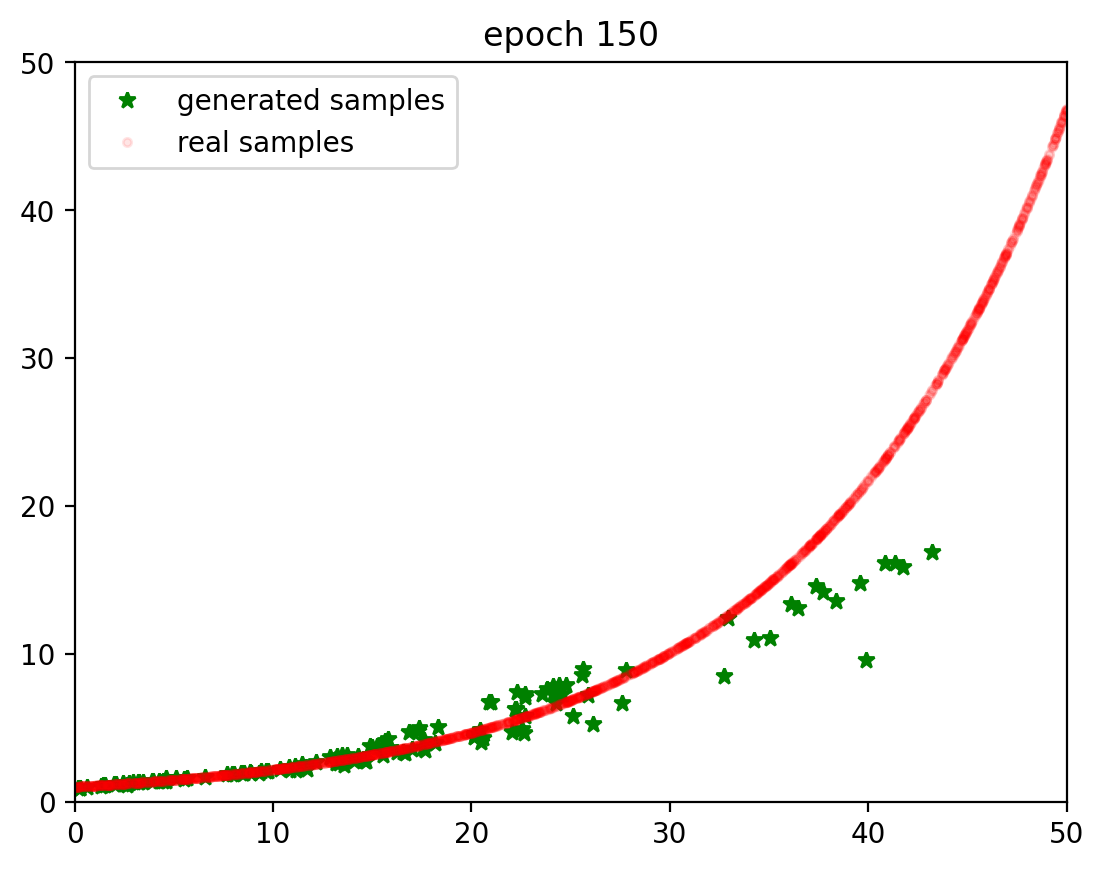

epoch 175, G_loss: 0.9028527577718098, D_loss 1.2919358571370443


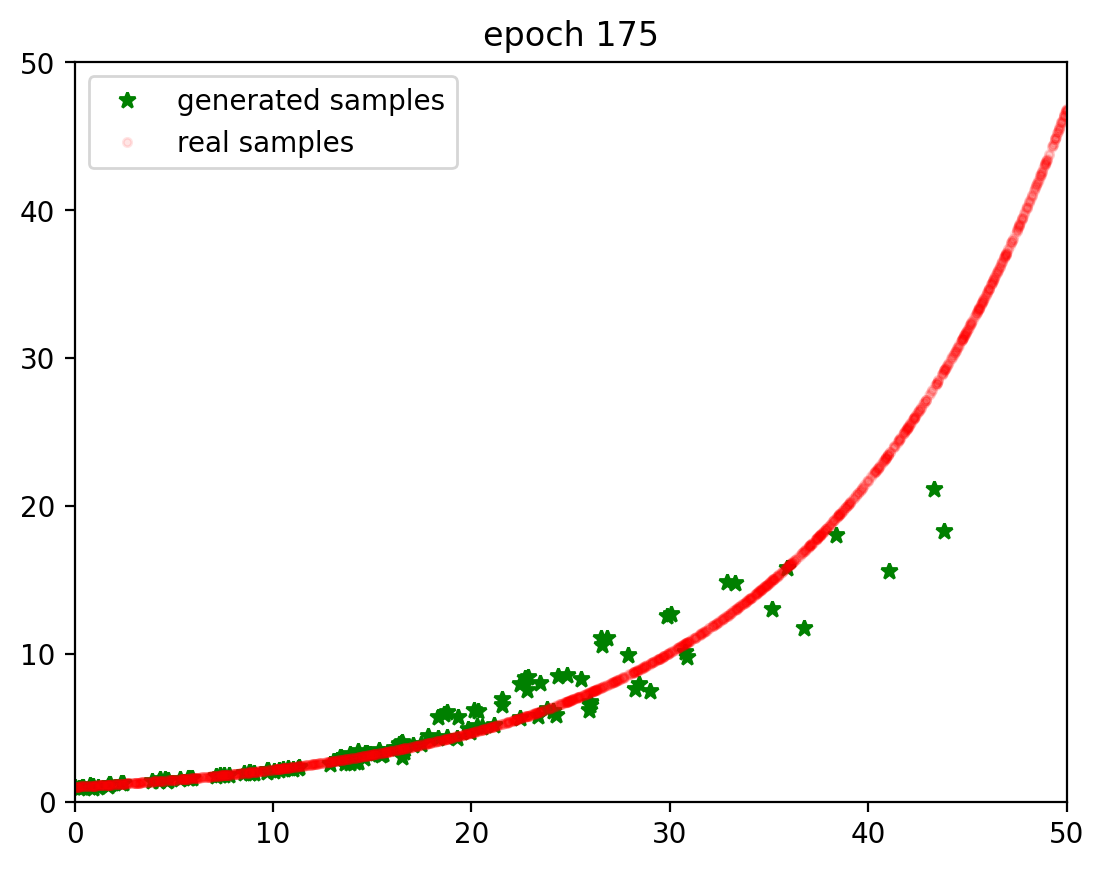

epoch 200, G_loss: 0.8499535878499349, D_loss 1.3343621571858724


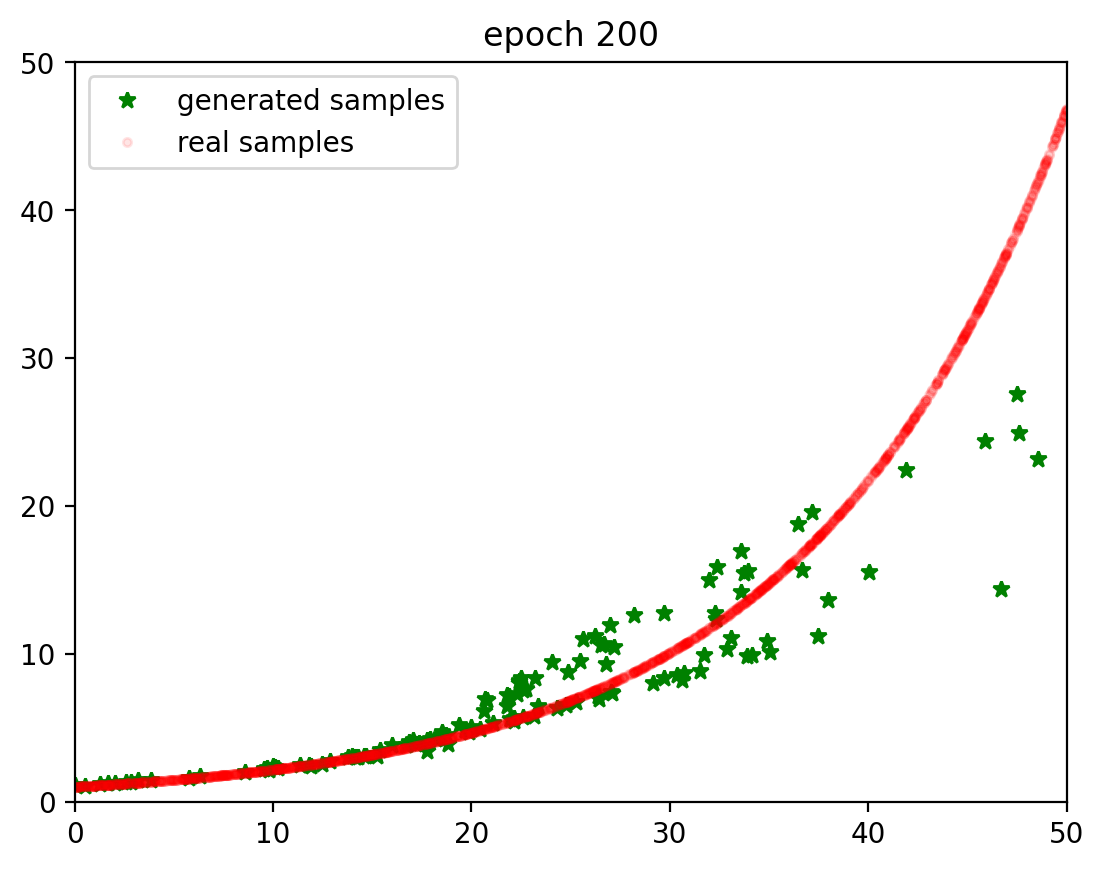

epoch 225, G_loss: 0.824657122294108, D_loss 1.4024283091227214


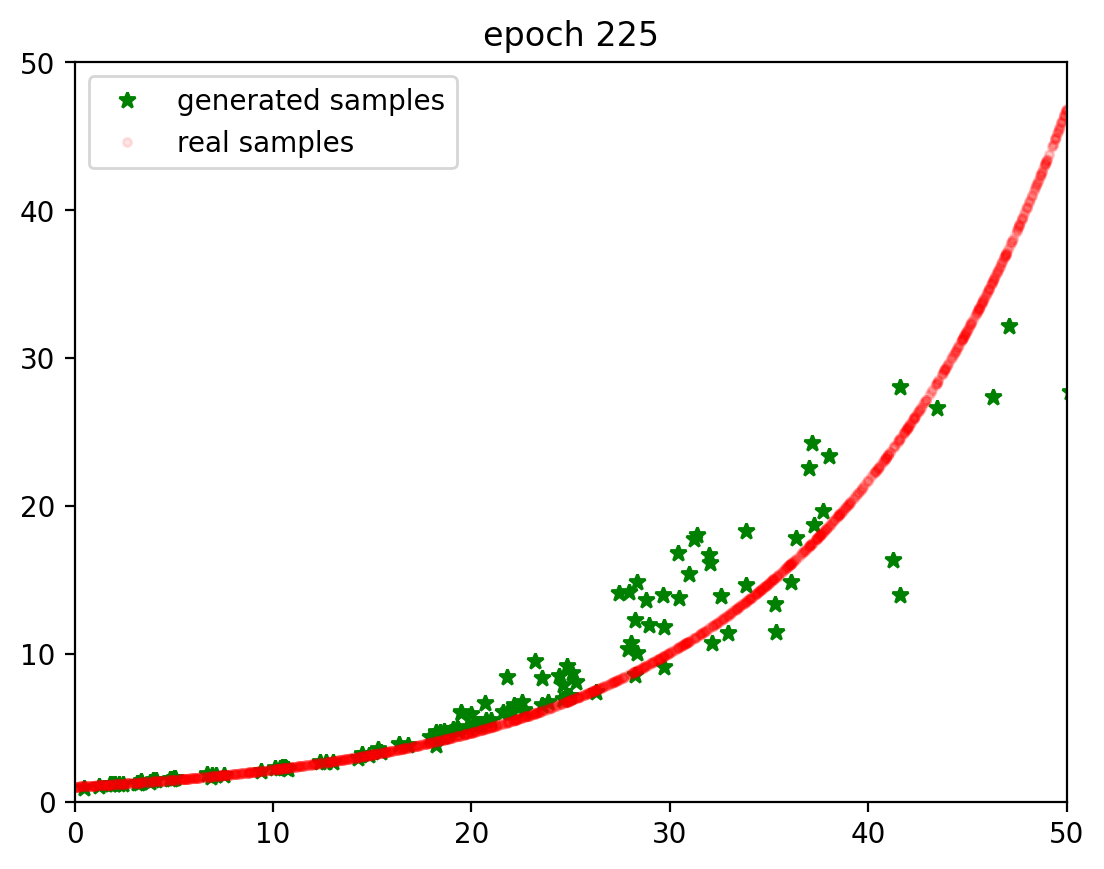

epoch 250, G_loss: 0.7990484237670898, D_loss 1.4565064748128256


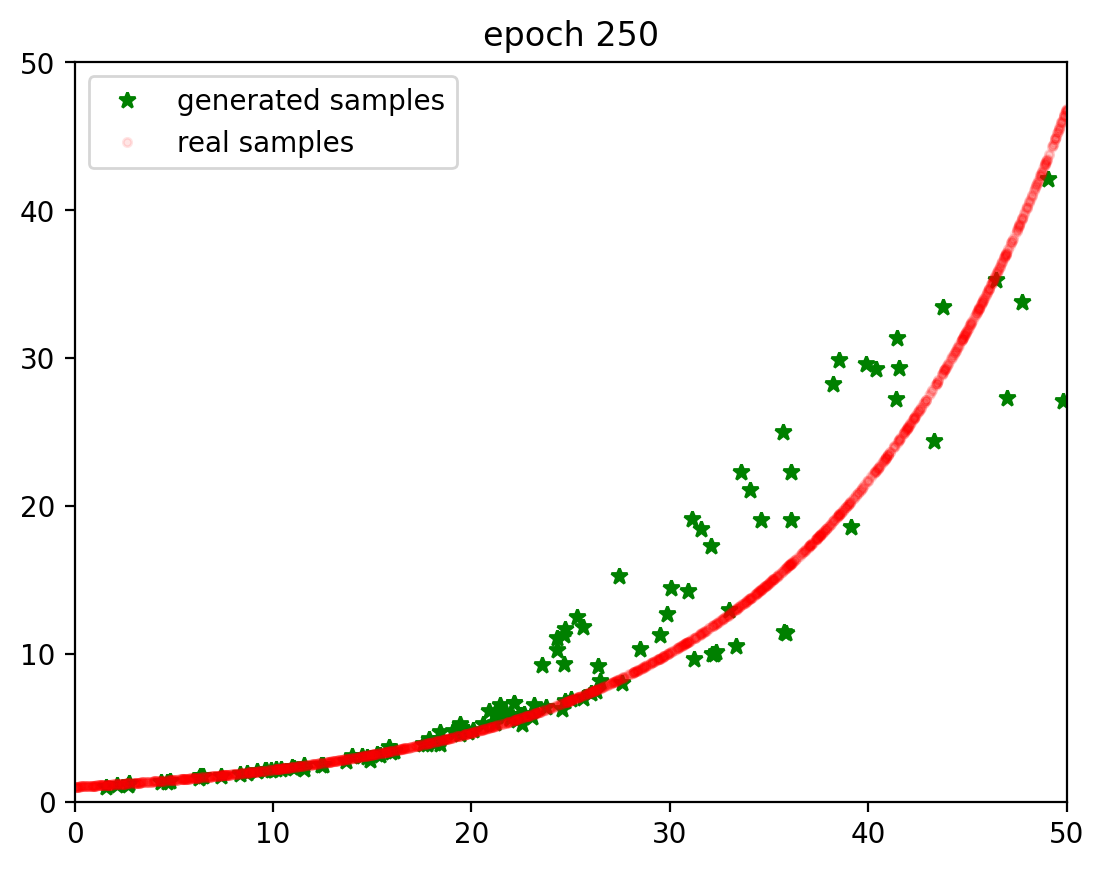

epoch 275, G_loss: 0.7717961629231771, D_loss 1.4706707000732422


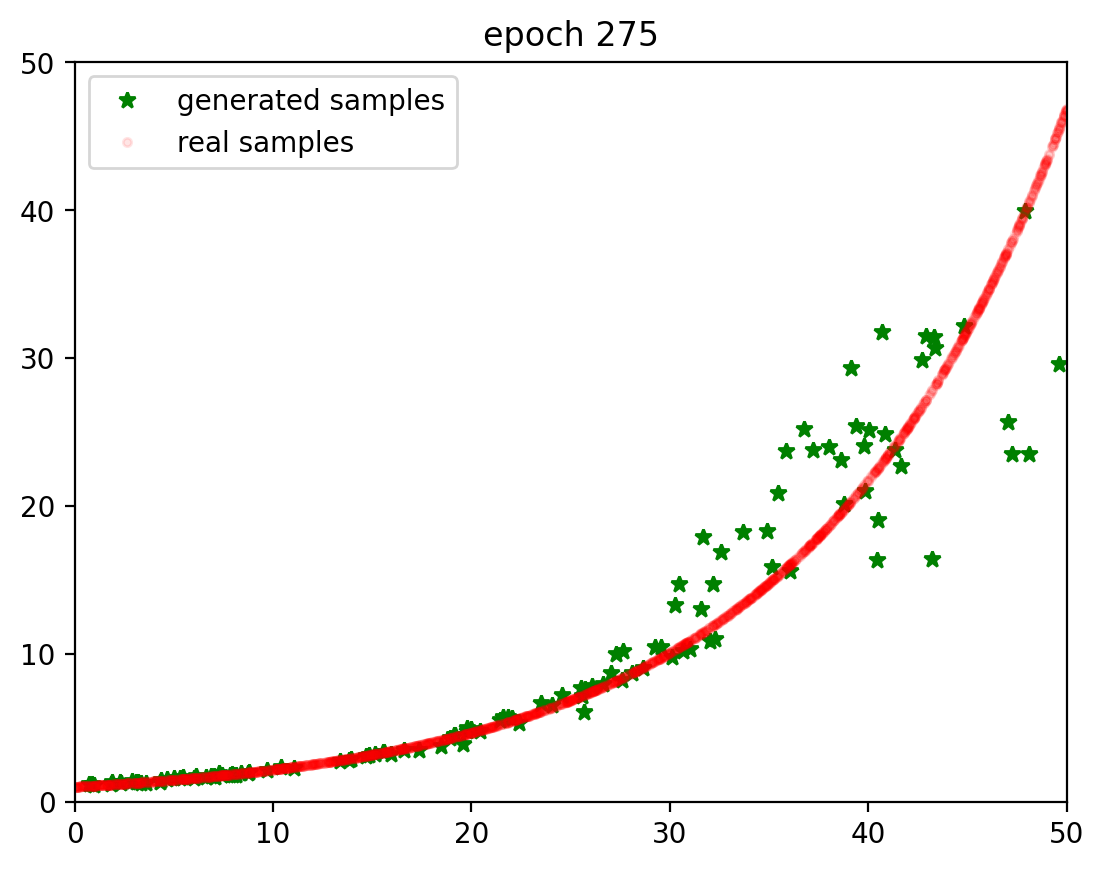

epoch 300, G_loss: 0.7790671666463216, D_loss 1.4784684499104819


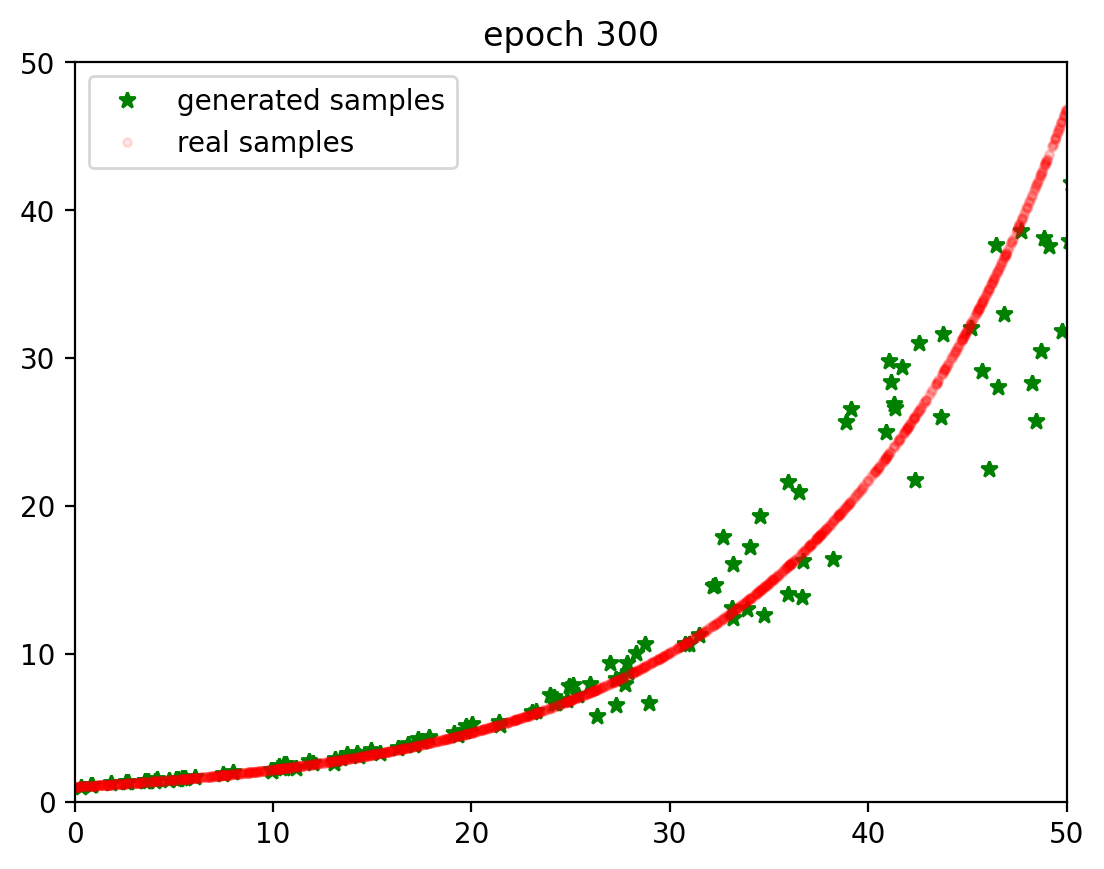

epoch 325, G_loss: 0.7630896250406901, D_loss 1.476935577392578


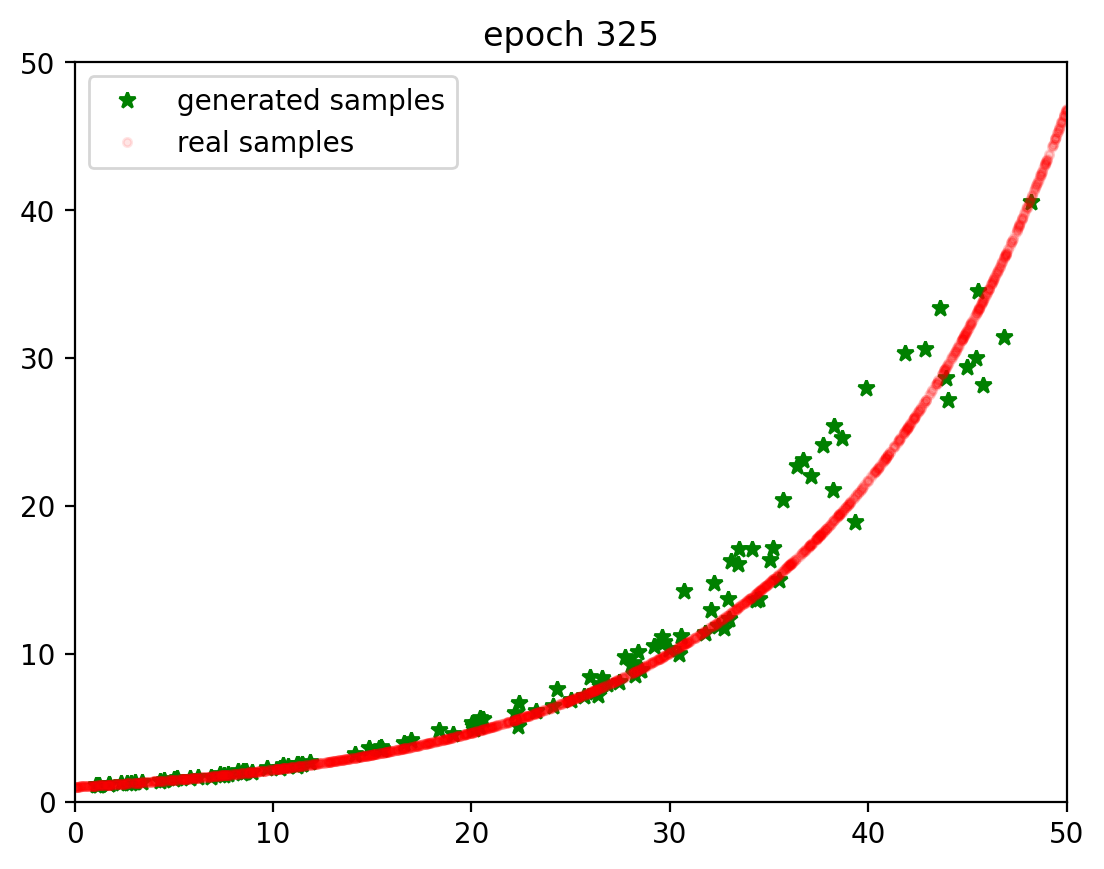

epoch 350, G_loss: 0.7591609319051107, D_loss 1.4743728637695312


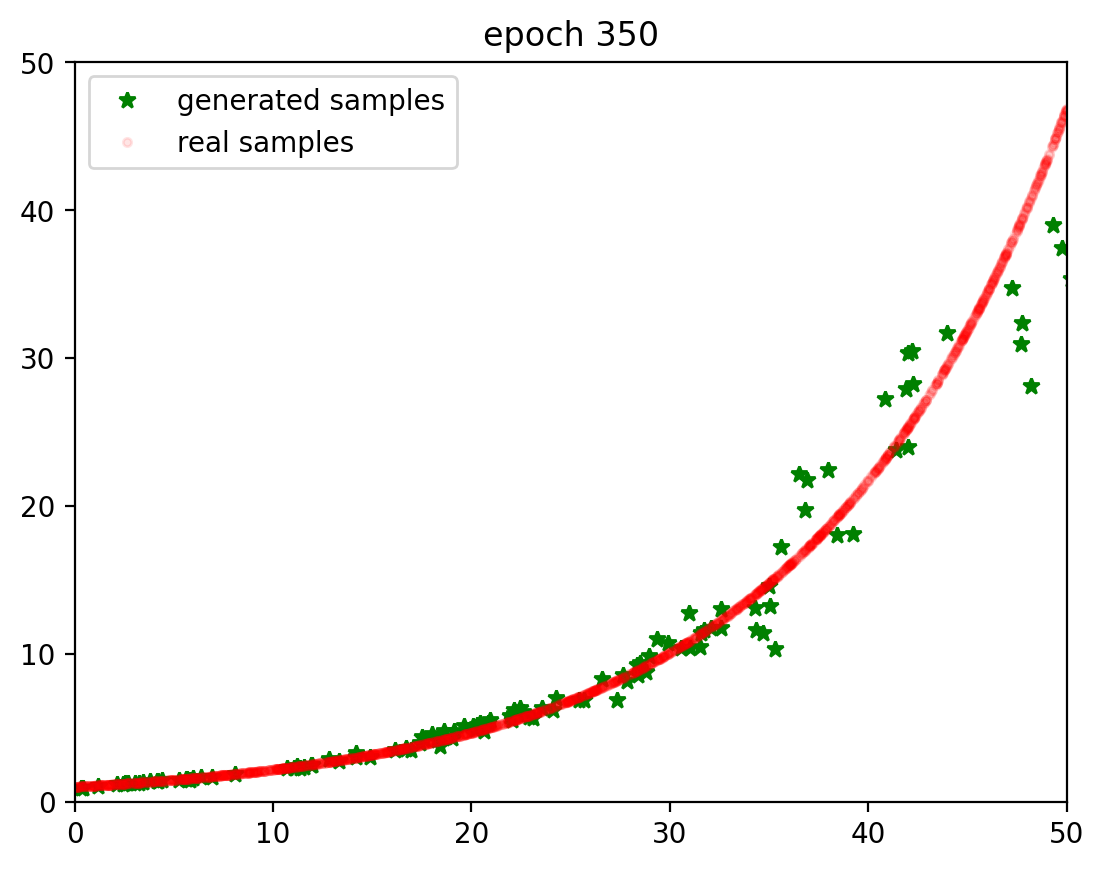

epoch 375, G_loss: 0.7680138905843099, D_loss 1.4714769999186197


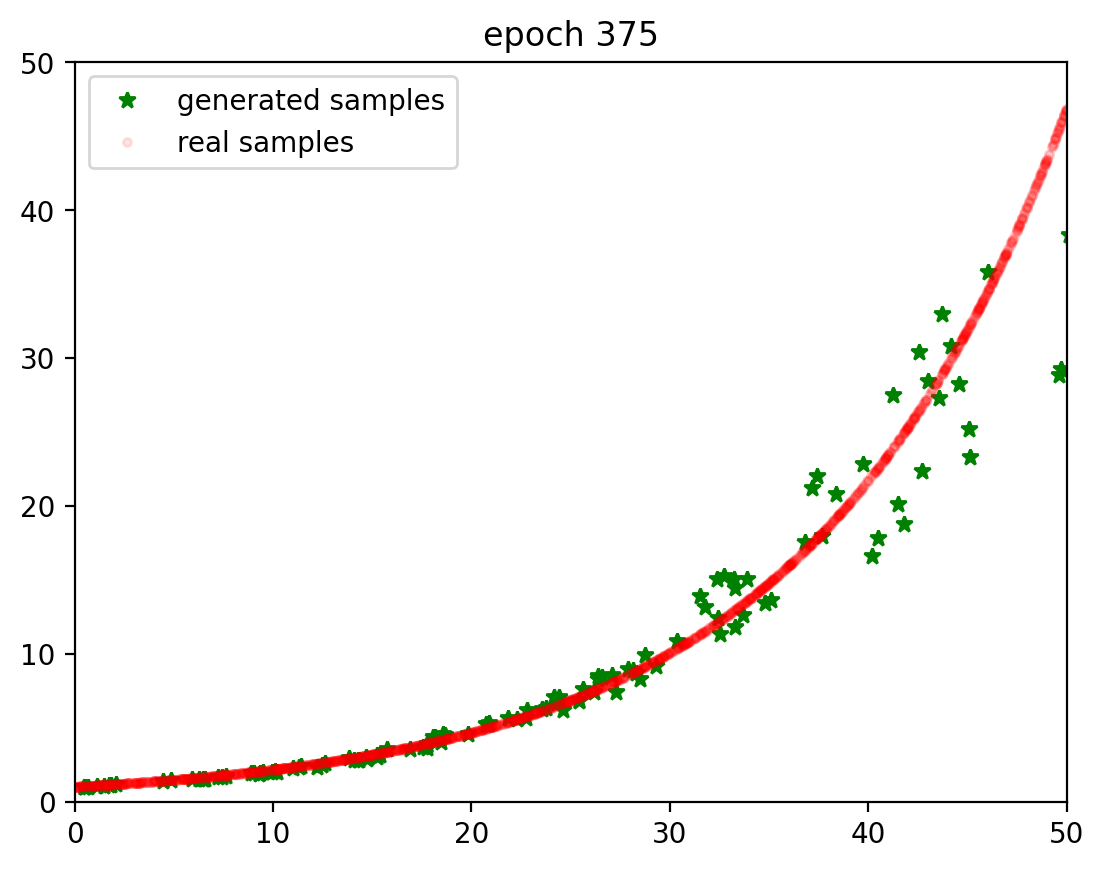

epoch 400, G_loss: 0.7516481399536132, D_loss 1.479175821940104


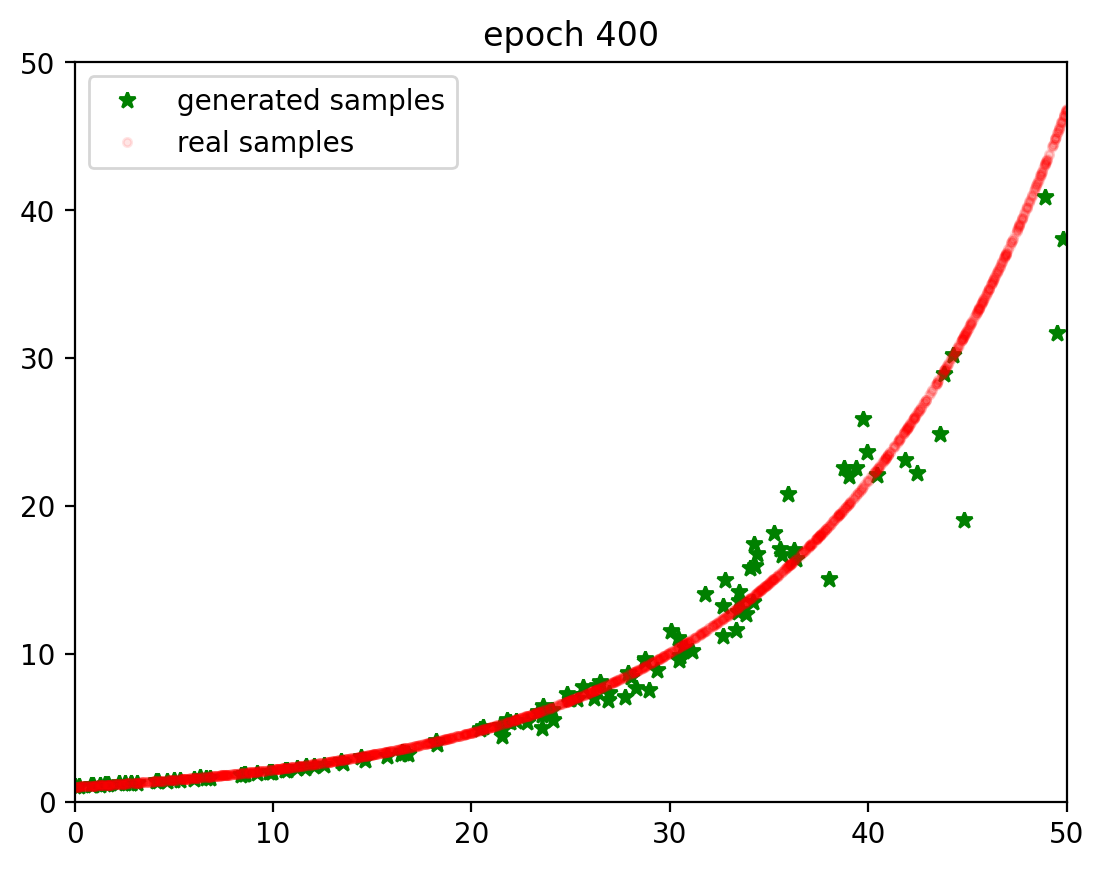

epoch 425, G_loss: 0.7726448059082032, D_loss 1.4717966715494792


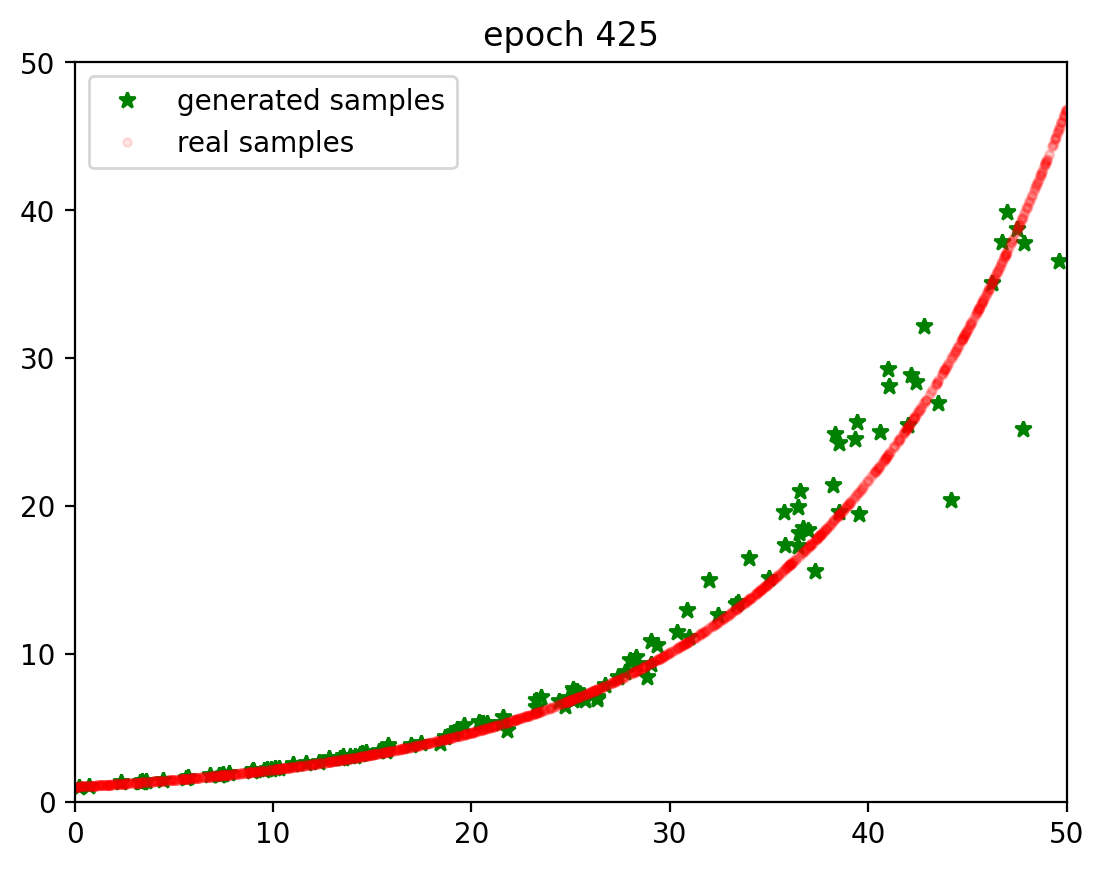

epoch 450, G_loss: 0.7752484639485677, D_loss 1.4746479034423827


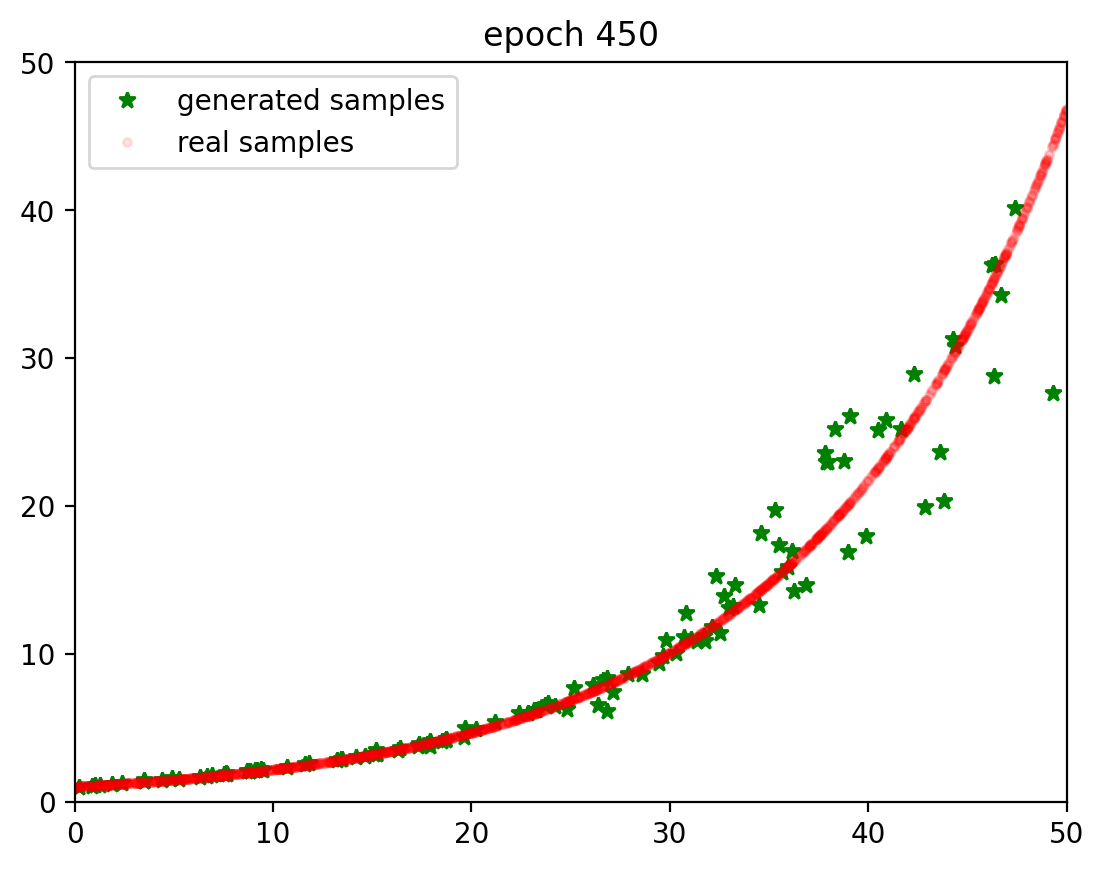

epoch 475, G_loss: 0.7683923085530598, D_loss 1.477203369140625


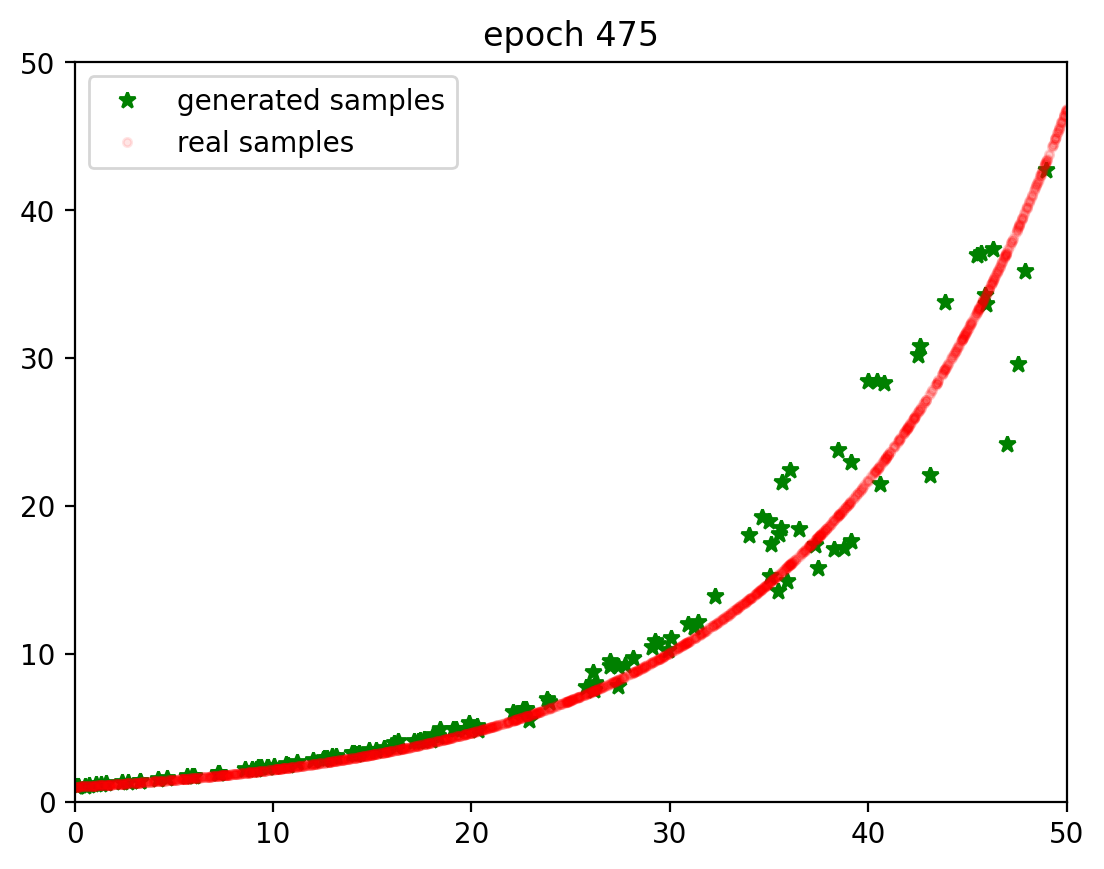

epoch 500, G_loss: 0.7572288513183594, D_loss 1.472722880045573


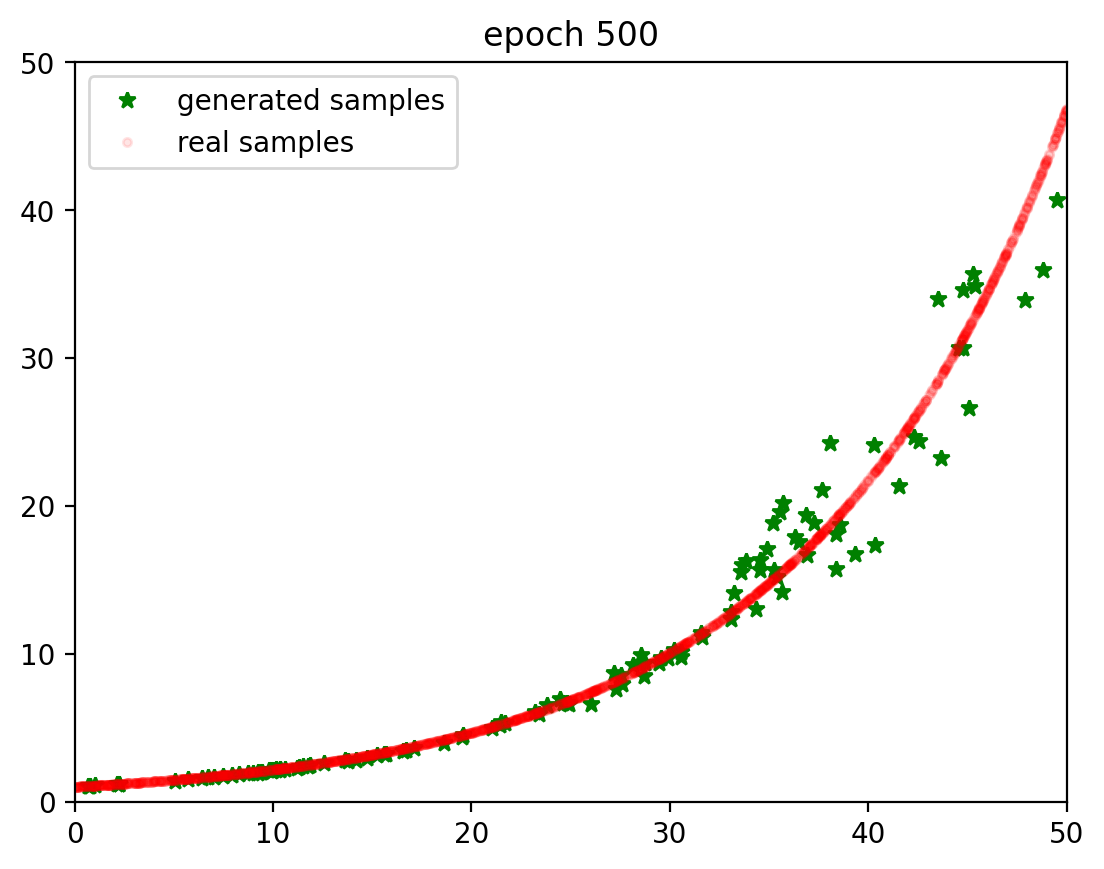

epoch 525, G_loss: 0.7880120595296224, D_loss 1.4679566701253255


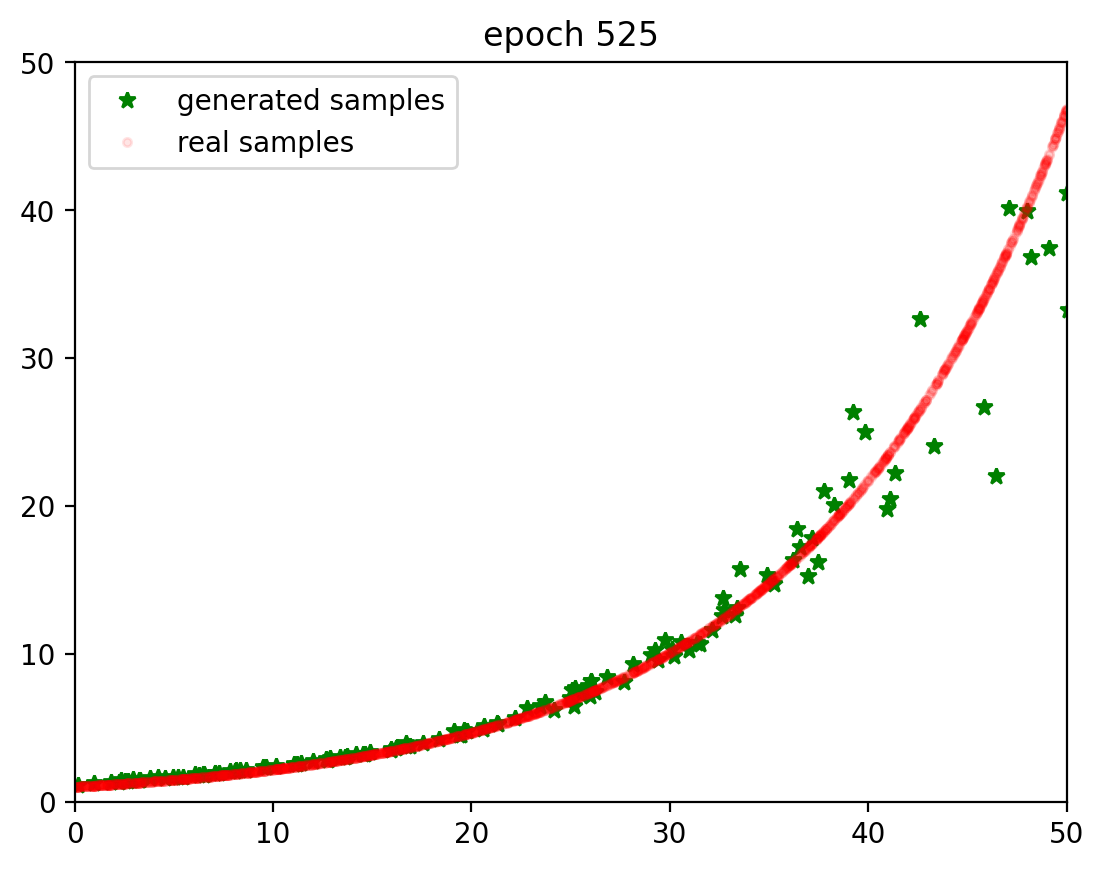

epoch 550, G_loss: 0.7719916025797526, D_loss 1.4764699300130208


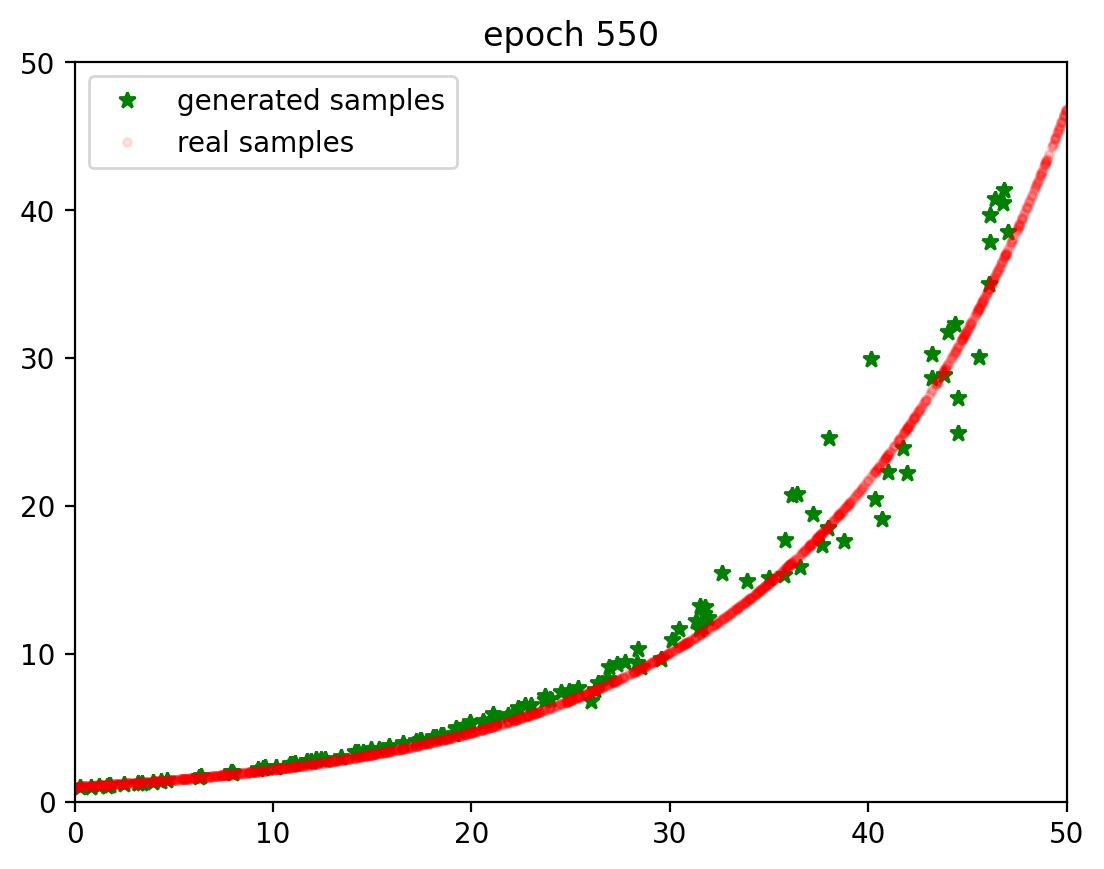

epoch 575, G_loss: 0.7551099777221679, D_loss 1.4725462595621746


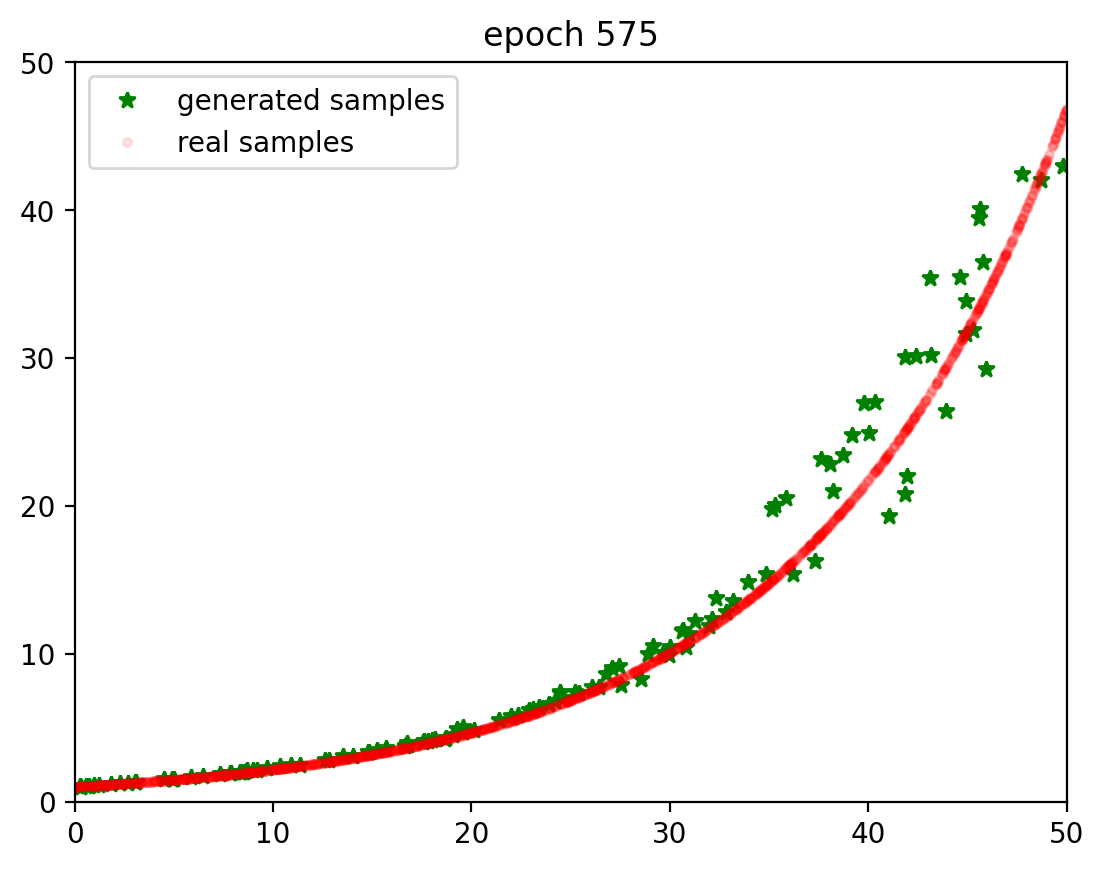

epoch 600, G_loss: 0.7783669789632162, D_loss 1.4669916788736979


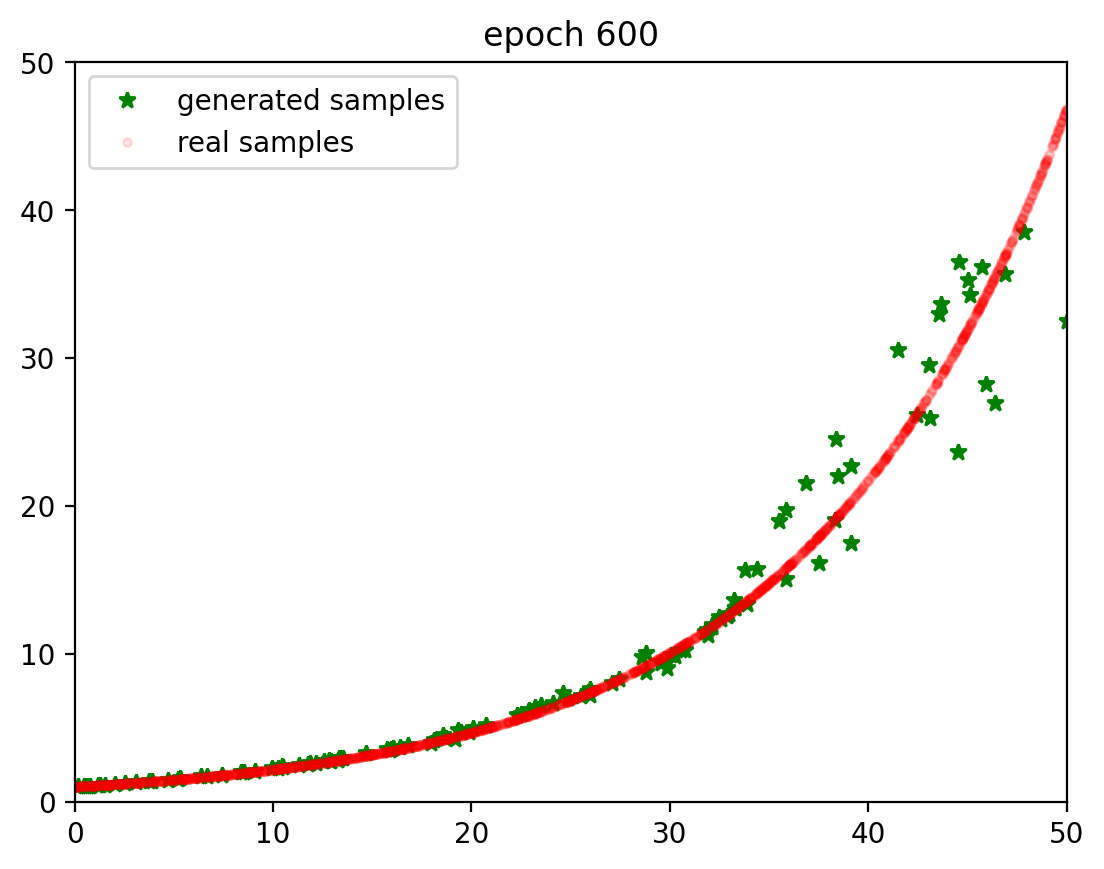

epoch 625, G_loss: 0.7720590591430664, D_loss 1.4650201161702474


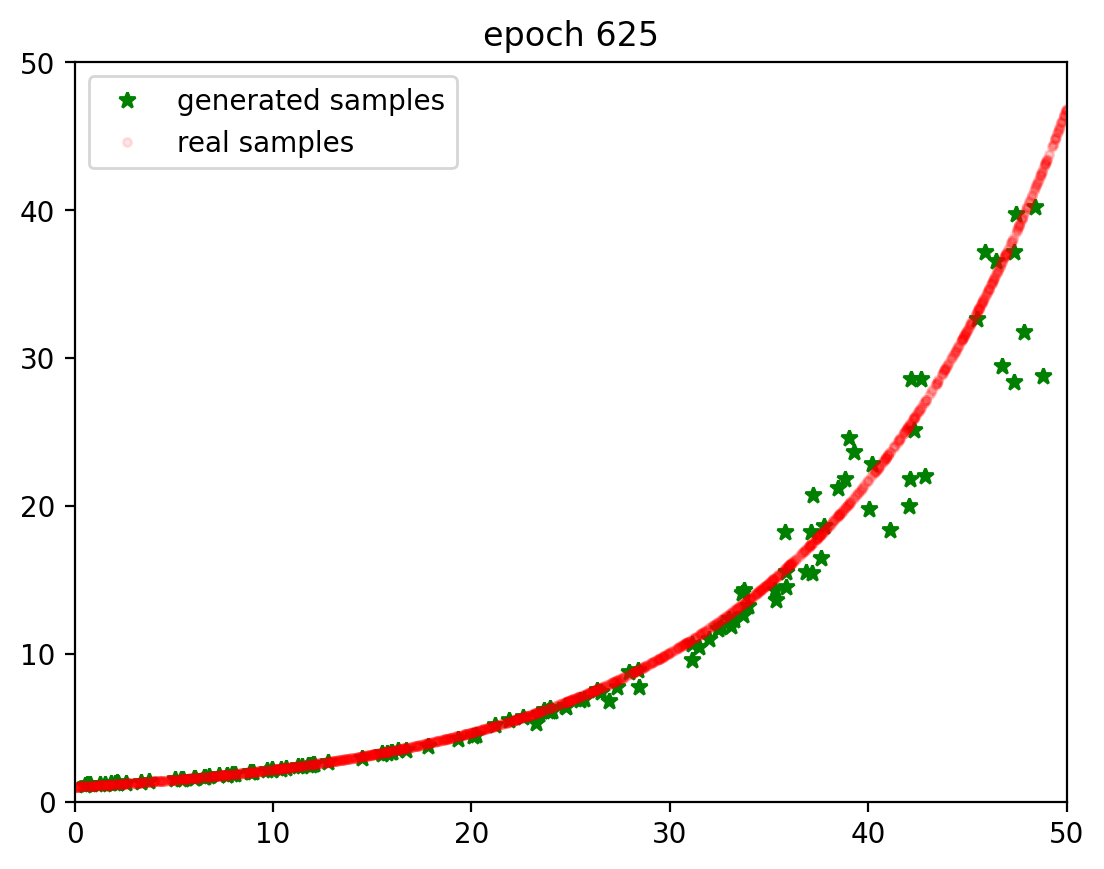

epoch 650, G_loss: 0.752545166015625, D_loss 1.4710792541503905


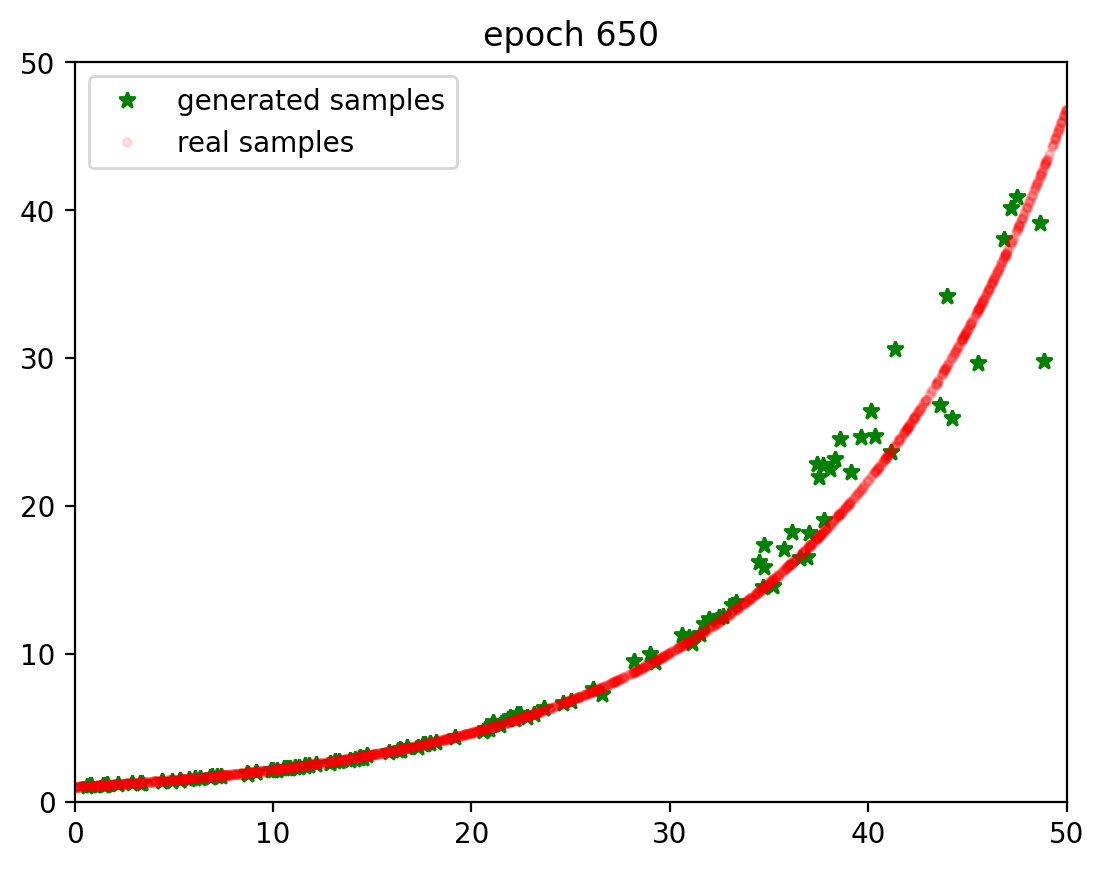

epoch 675, G_loss: 0.7623524347941081, D_loss 1.478405507405599


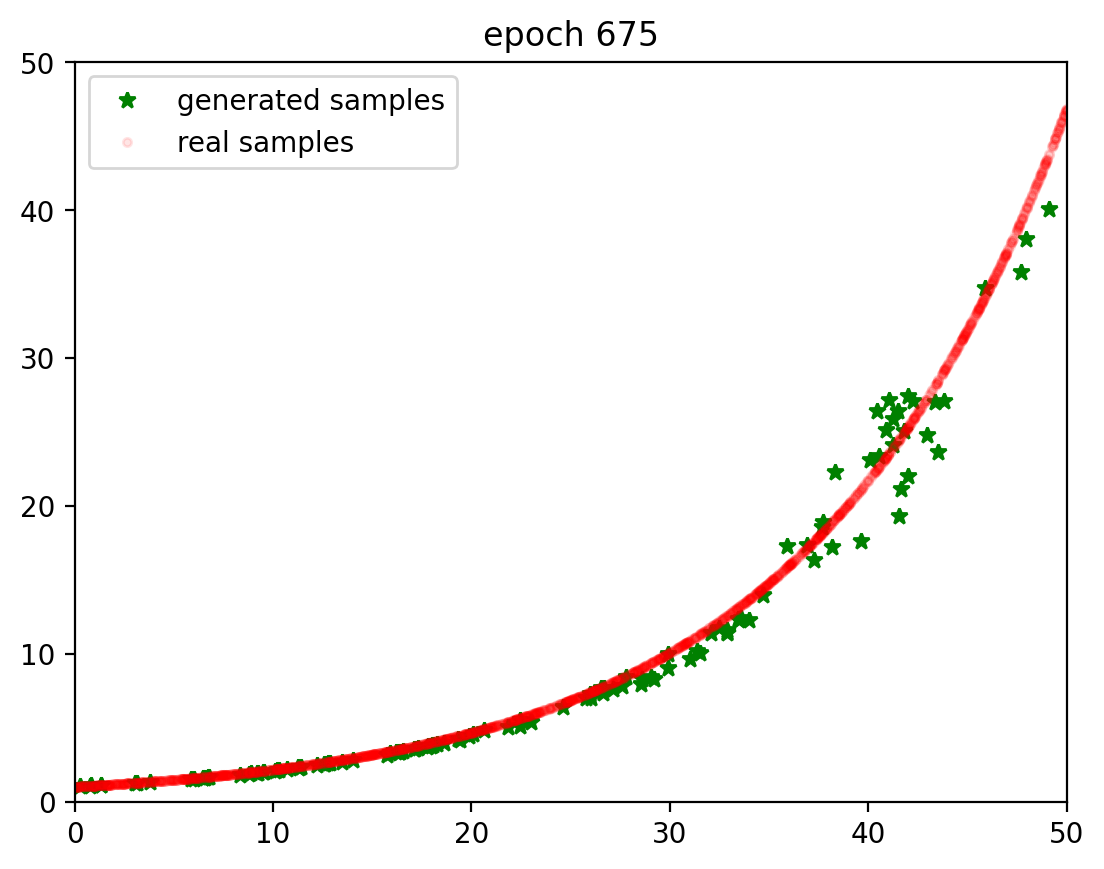

epoch 700, G_loss: 0.755871327718099, D_loss 1.4782483418782553


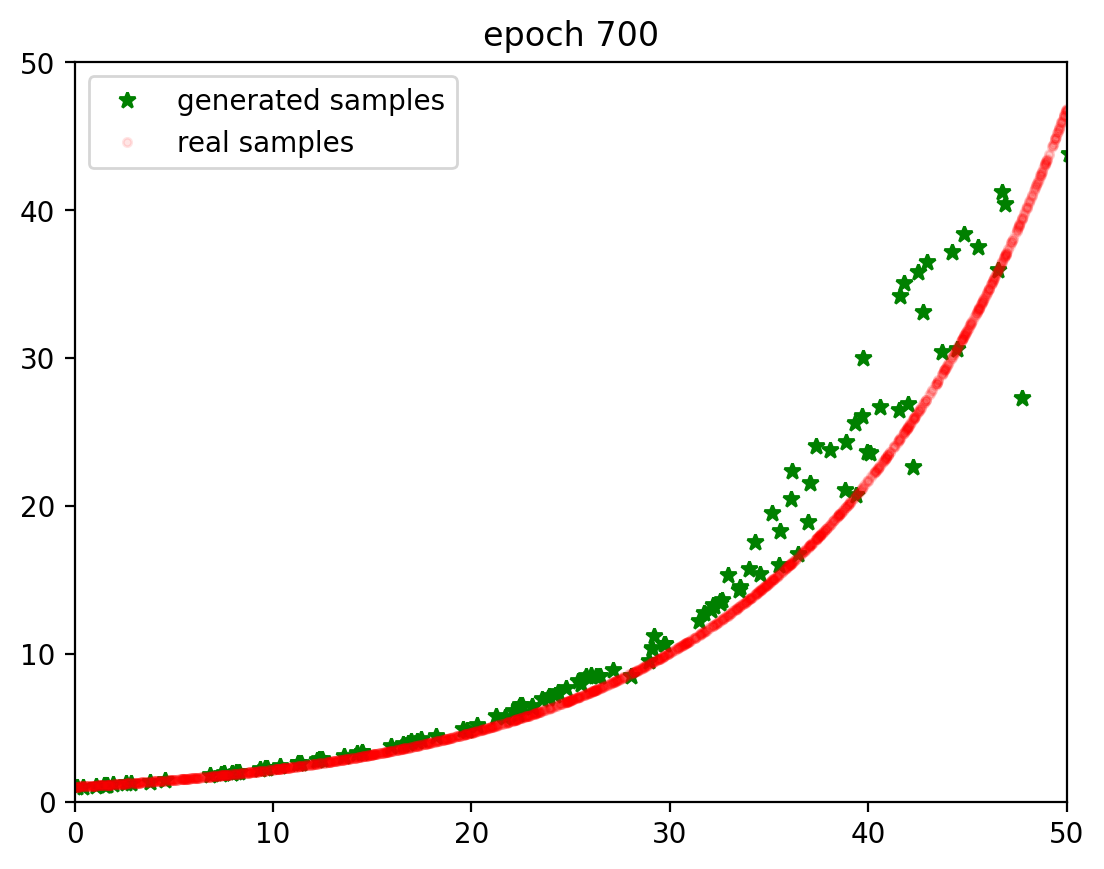

epoch 725, G_loss: 0.7663618087768554, D_loss 1.4657863616943358


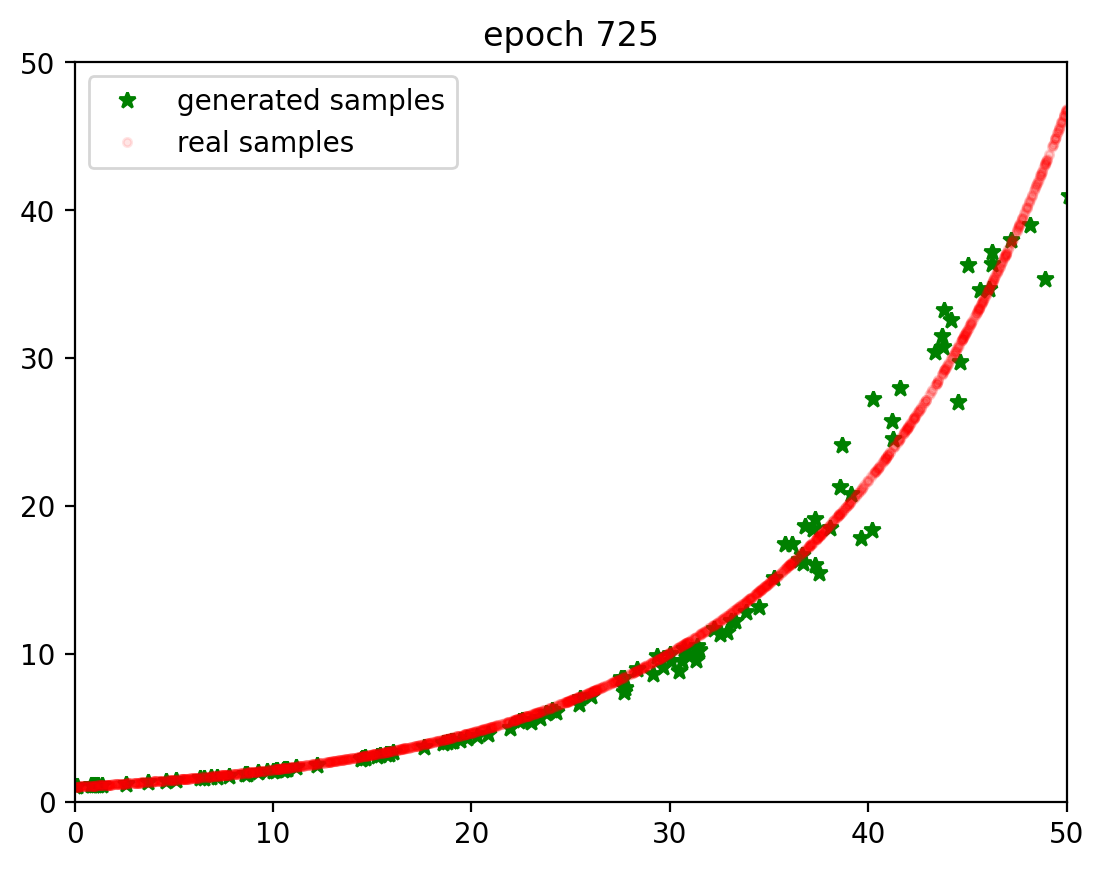

epoch 750, G_loss: 0.7330802917480469, D_loss 1.479027303059896


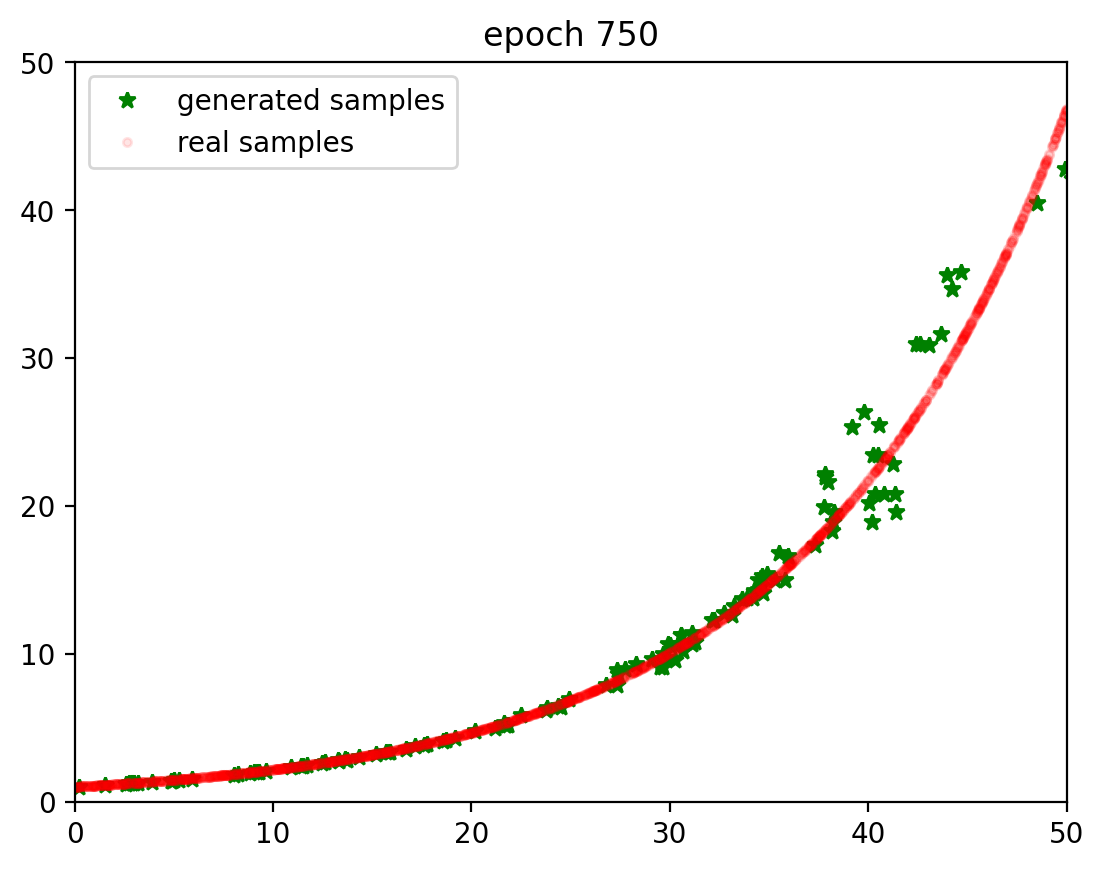

epoch 775, G_loss: 0.7550768534342448, D_loss 1.4745366414388021


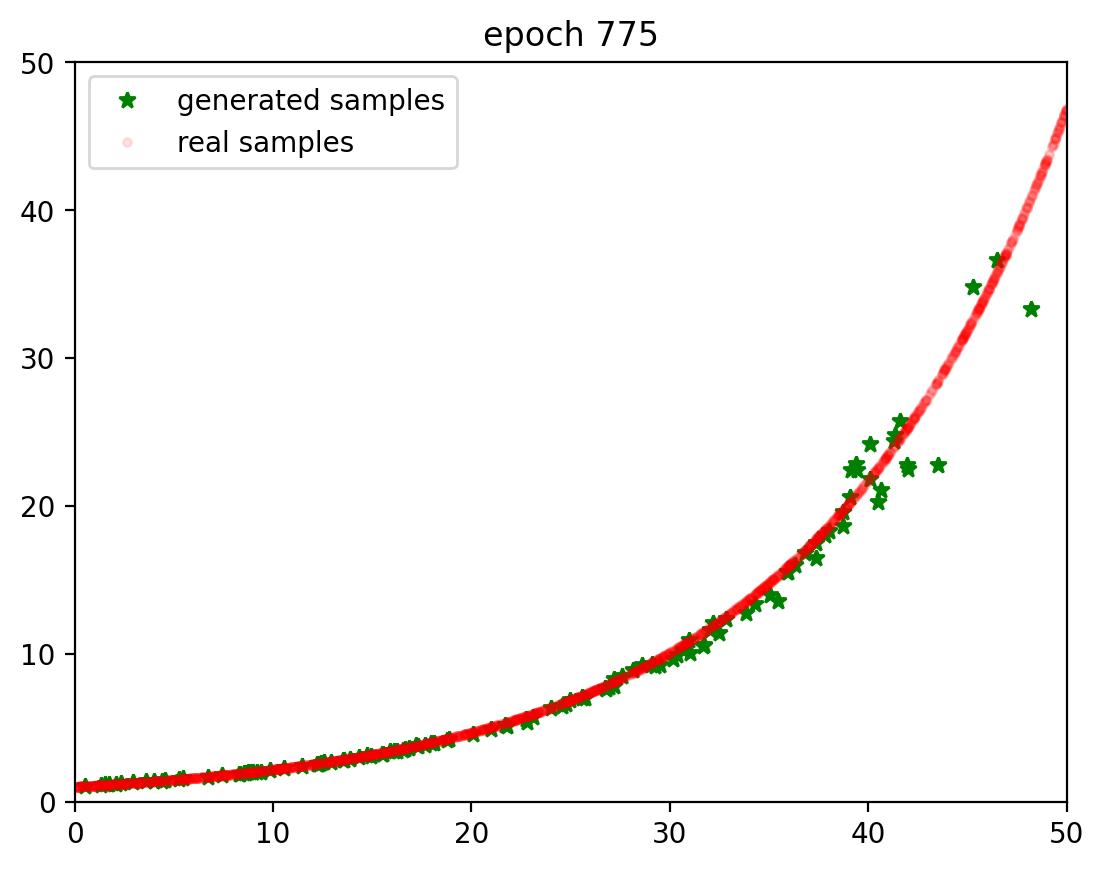

epoch 800, G_loss: 0.7575670878092448, D_loss 1.4737452189127604


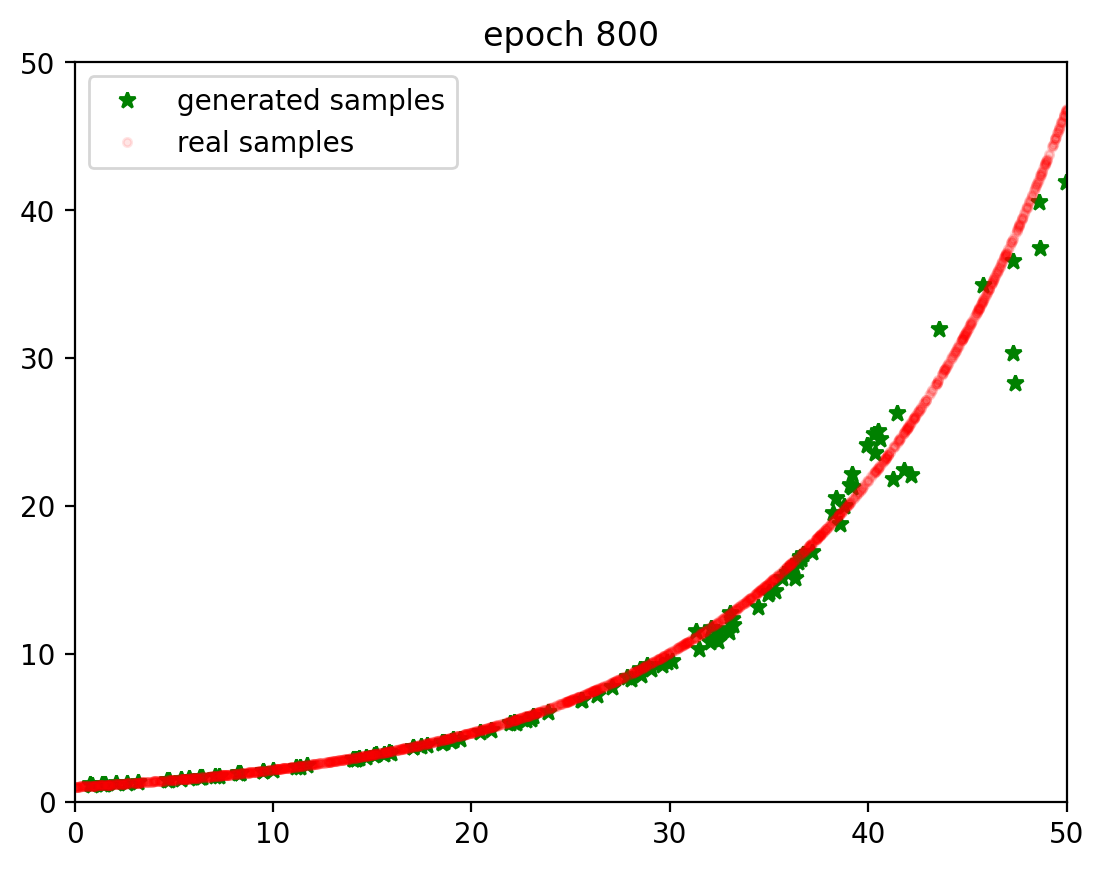

epoch 825, G_loss: 0.7587368011474609, D_loss 1.4702253977457682


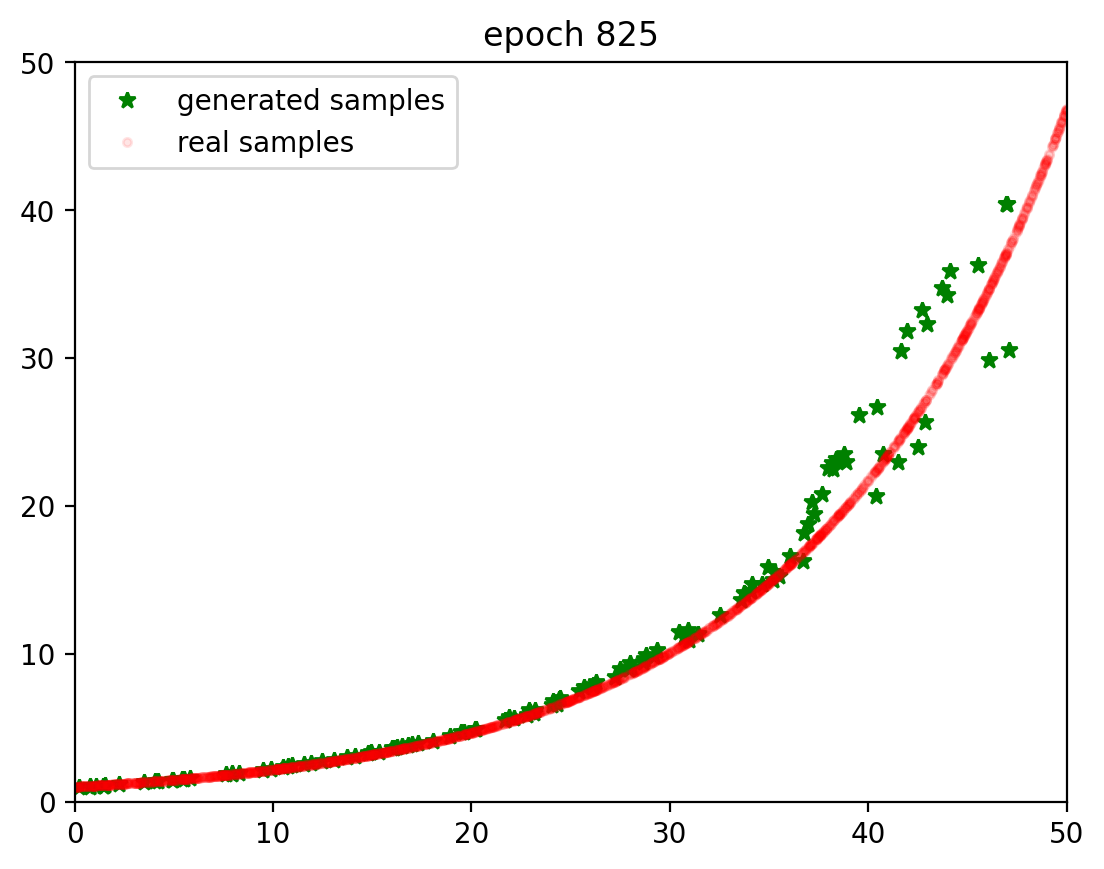

epoch 850, G_loss: 0.7783666610717773, D_loss 1.4706350962320964


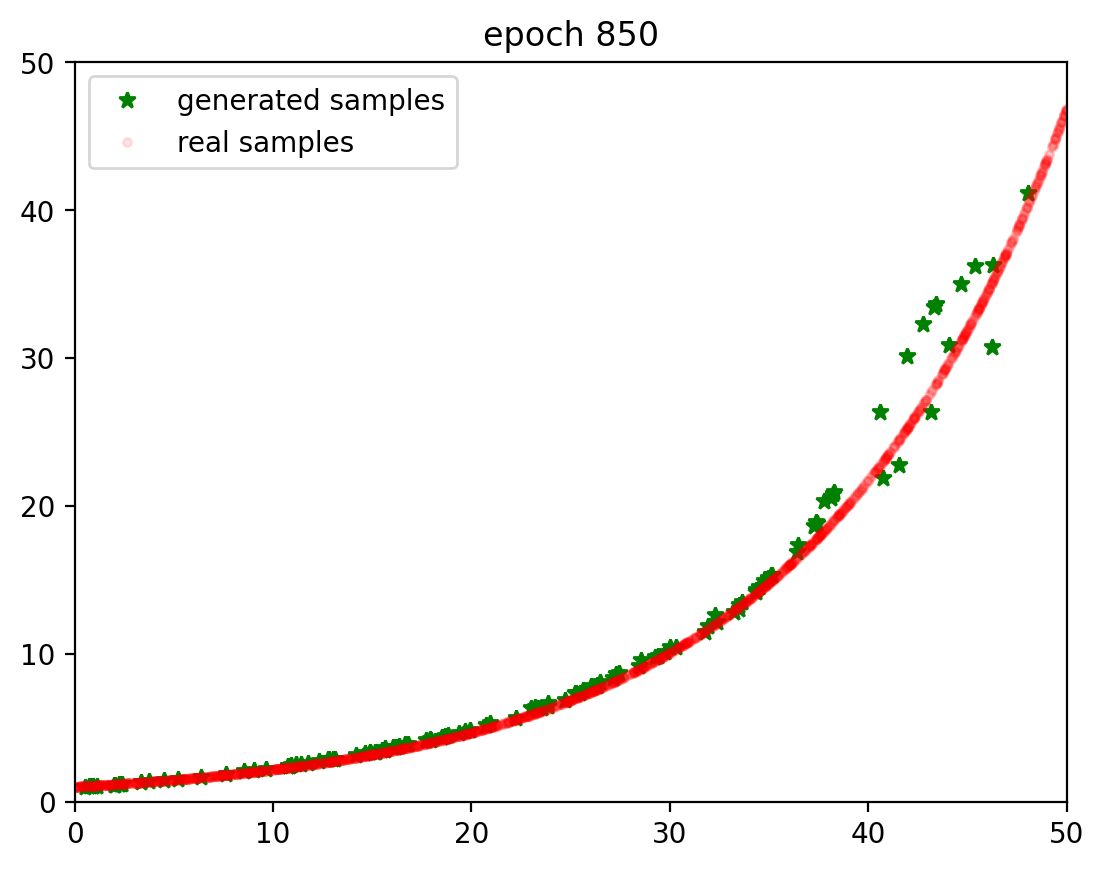

epoch 875, G_loss: 0.7499004999796549, D_loss 1.473560587565104


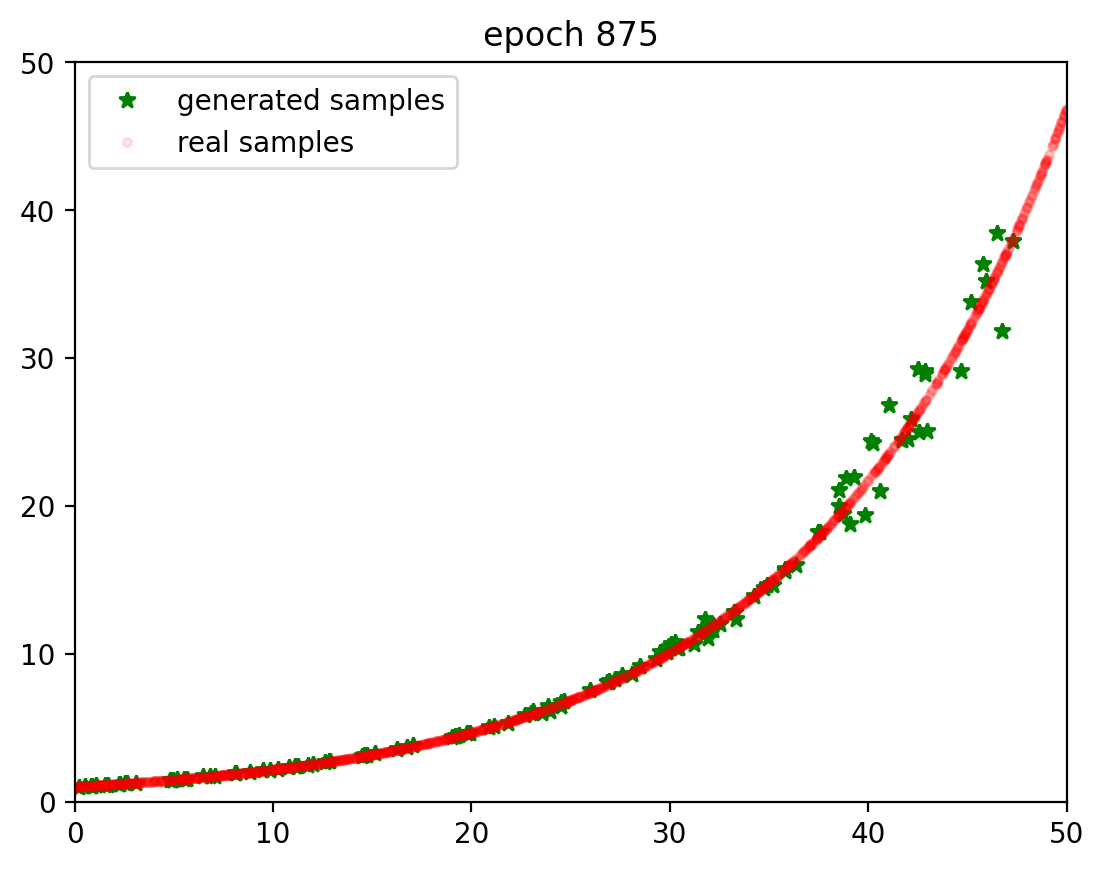

epoch 900, G_loss: 0.7709625879923503, D_loss 1.4648457845052083


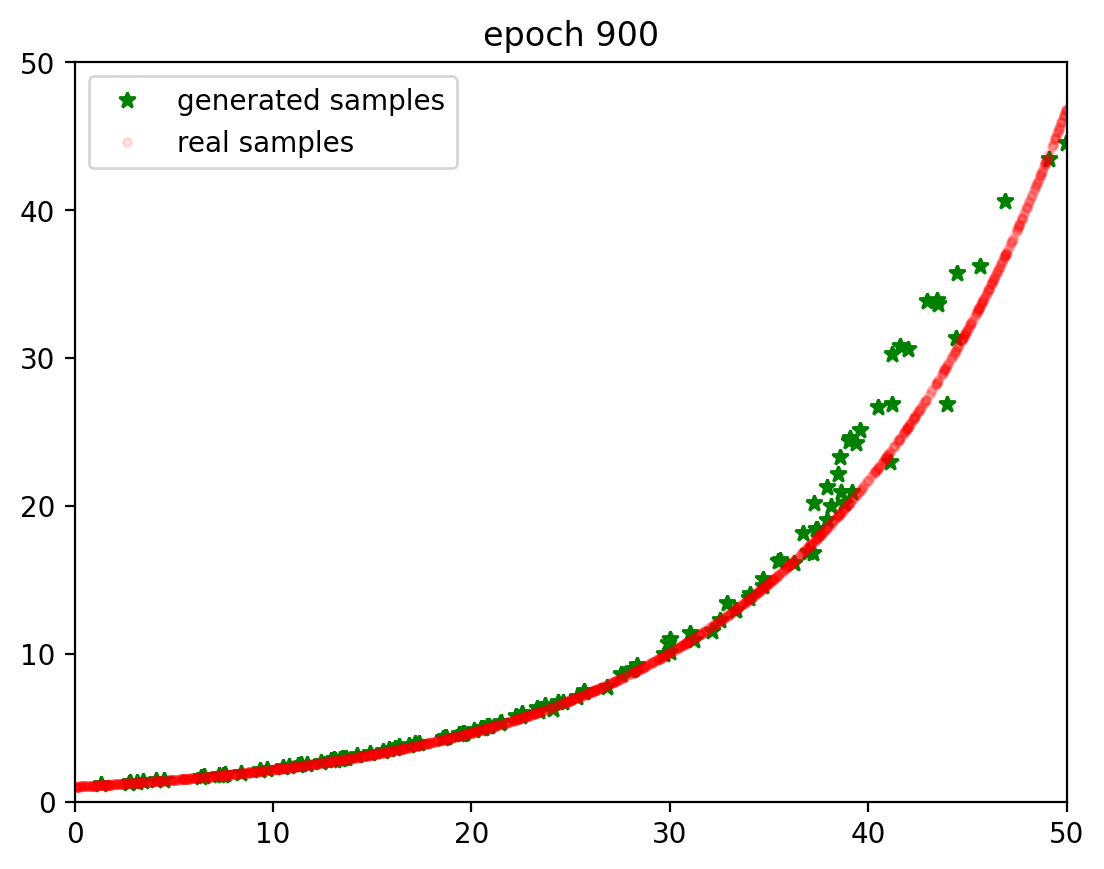

epoch 925, G_loss: 0.7660325368245443, D_loss 1.4651870727539062


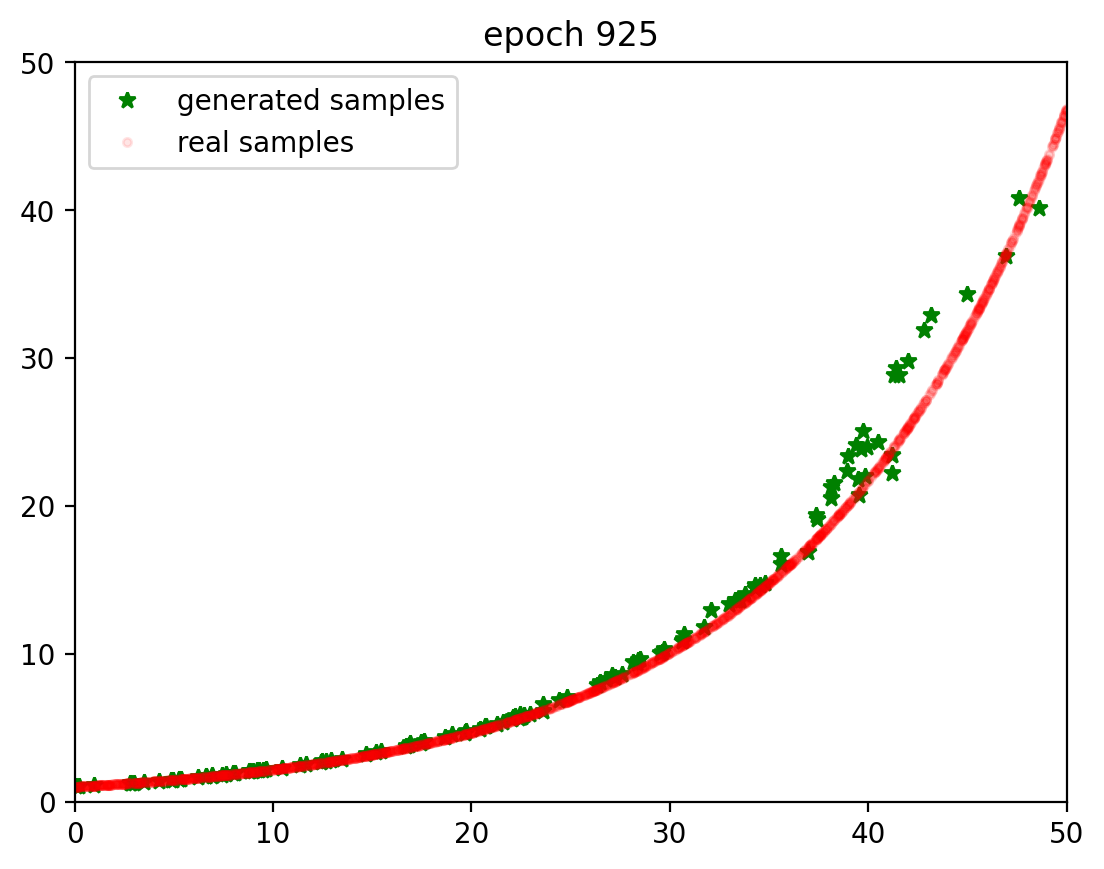

epoch 950, G_loss: 0.8030666987101237, D_loss 1.4293331146240233


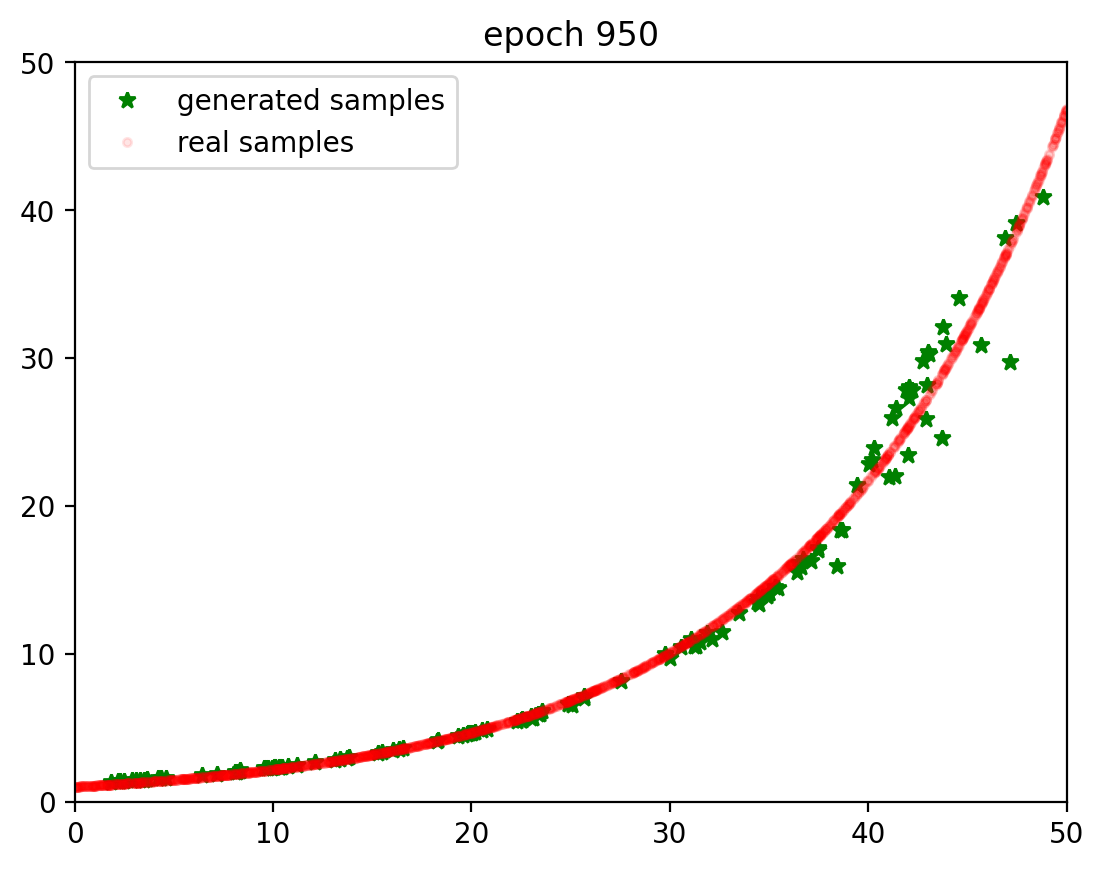

epoch 975, G_loss: 0.7885708491007487, D_loss 1.4639158884684245


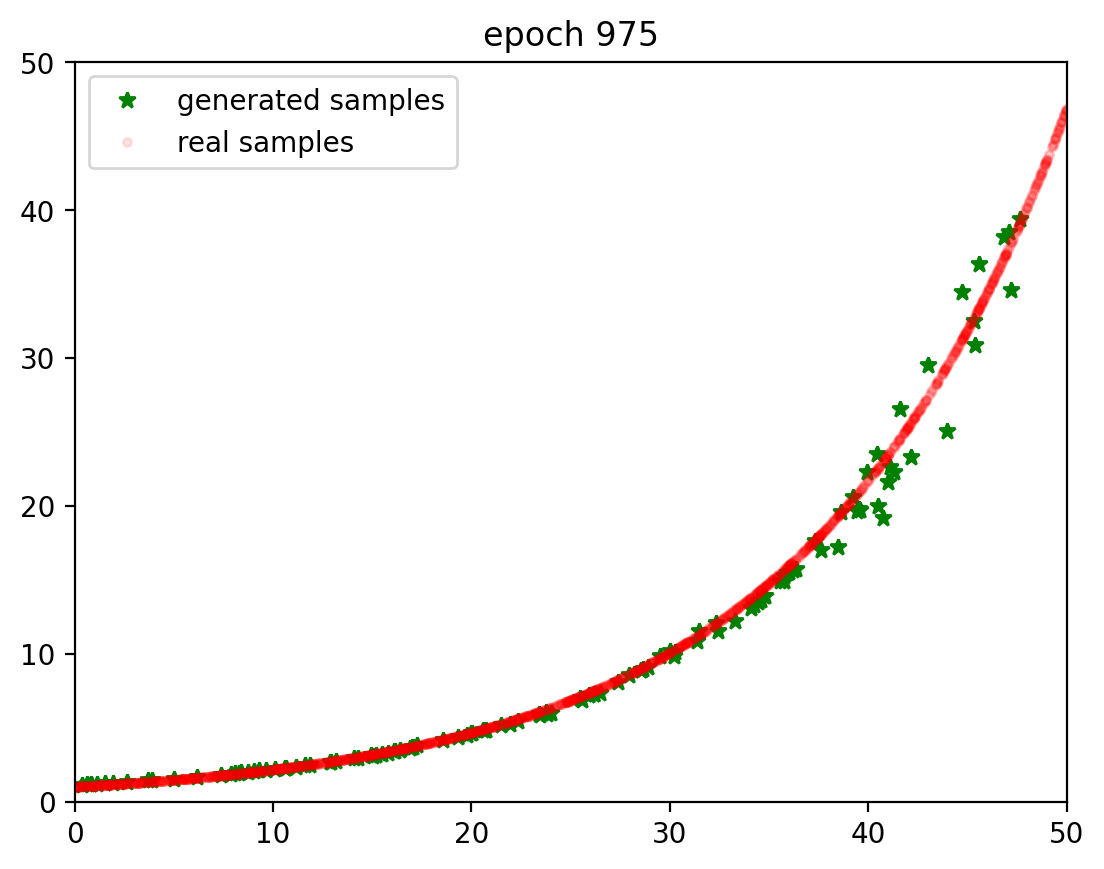

epoch 1000, G_loss: 0.7772693634033203, D_loss 1.4516043345133463


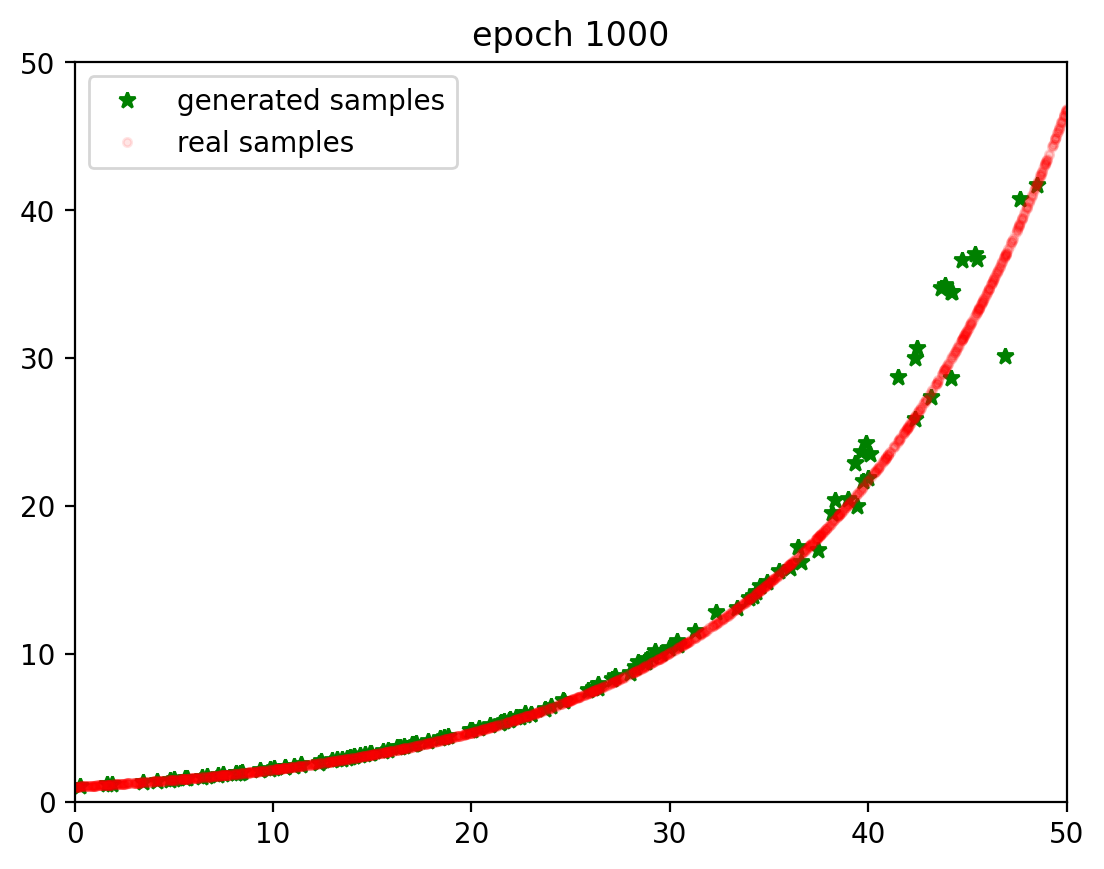

epoch 1025, G_loss: 0.7911607106526692, D_loss 1.4489142100016277


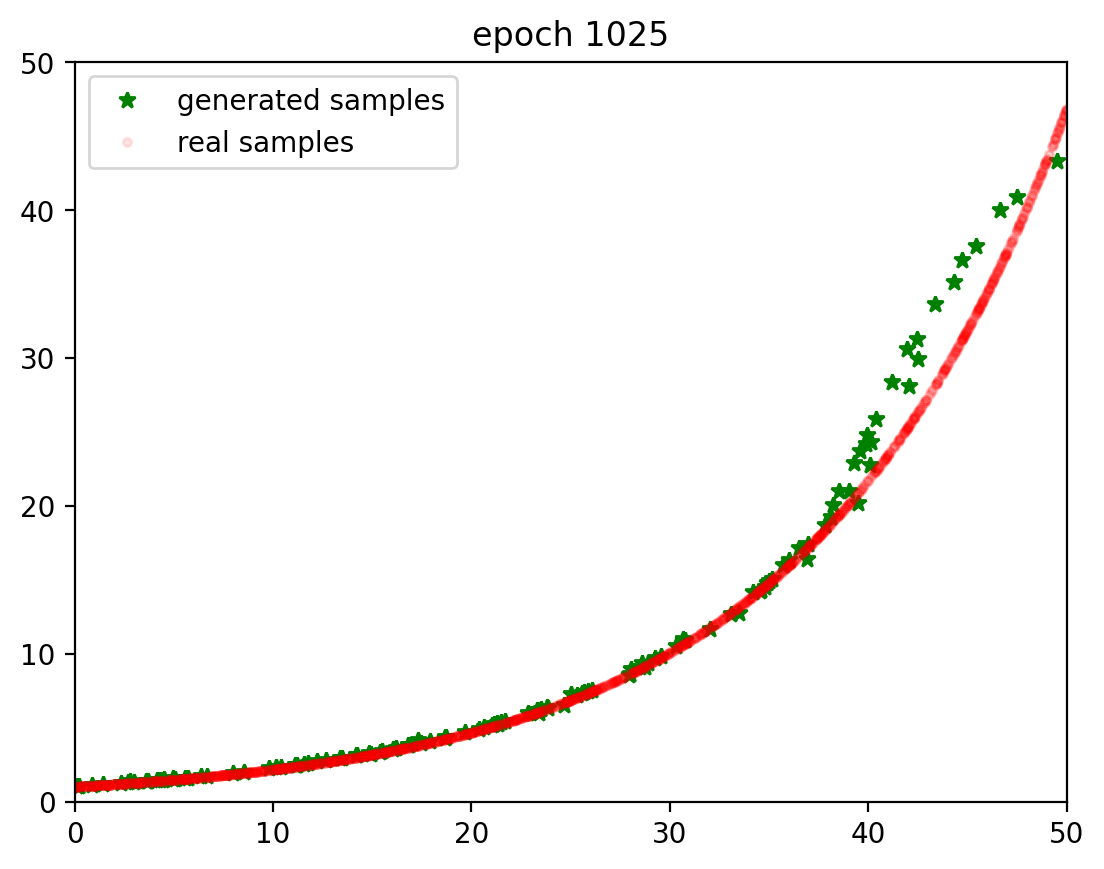

In [14]:
# training the GAN 

for epoch in range(10000):
    g_loss = 0
    d_loss = 0

    for n, real_samples in enumerate(train_loader): # iterate through all batches in training data
        loss_D = train_D_on_real(real_samples)
        d_loss += loss_D
        loss_D = train_D_on_fake()
        d_loss += loss_D
        loss_G, fake_samples = train_G()
        g_loss += loss_G
    
    test_epoch(epoch, g_loss, d_loss, n, fake_samples)
    g_diff = performance(fake_samples).item()
    
    if stopper.stop(g_diff)==True:
        break


In [16]:
# discarding the discrimator and saving the trained generator

import os

os.makedirs("files", exist_ok=True)
scripted = torch.jit.script(generator)
scripted.save('files/exponential.pt')

The `torch.jit.script()` method scripts a function or a `nn.Module` class as TorchScript code using the TorchScript compiler. We use the method to script our trained generator network and save it as a file, `exponential.pt`, on your computer.

In [17]:
# to use the generator:

new_gen = torch.jit.load('files/exponential.pt', 
                         map_location=device) # trained gen loaded to the device (mps in this case)
new_gen.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
  (1): RecursiveScriptModule(original_name=ReLU)
  (2): RecursiveScriptModule(original_name=Linear)
  (3): RecursiveScriptModule(original_name=ReLU)
  (4): RecursiveScriptModule(original_name=Linear)
)

In [18]:
# using the trained generator to generate a batch of data

noise = torch.randn((batch_size, 2)).to(device) # get batch of random noise vectors from latent space
new_data = new_gen(noise)   # feed to gen to produce fake data

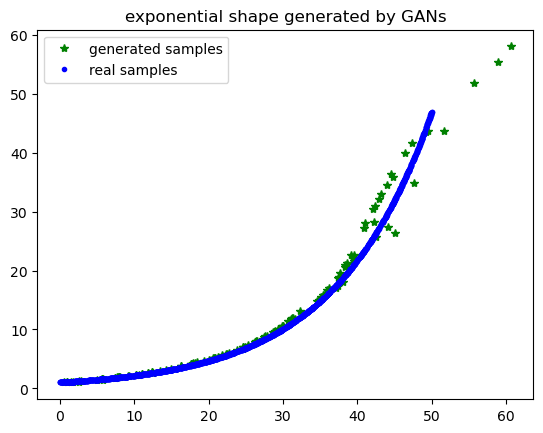

In [20]:
# plot the generated data

fig = plt.figure(dpi=100)

# plotting the generated data
plt.plot(new_data.detach().cpu().numpy()[:, 0], 
         new_data.detach().cpu().numpy()[:,1], "*", c="g",
         label="generated samples")

# plotting the real data
plt.plot(train_data[:, 0], 
         train_data[:,1], ".", c="b",
         label="real samples")

plt.title("exponential shape generated by GANs")

plt.legend()
plt.show()